# Paper Abstracts Analysis

By Rafael Ballestiero

In [62]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[50,20]
plt.rcParams['font.size']=18
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20

# Change the PATH variable to the folder where the CSV file is stored.
PATH = '/Users/rafa/dv/INSEAD/abstracts'
FILENAME = 'data/papers_with_categories.csv'

os.chdir(PATH)

## 1. Get Abstracts for Paper

The first step in this is to parse the DOI links provided in the spreadsheet to retrieve the Abstracts of each of these players. This is done with the help of some HTML parsing libraries and a quick inspection of the page structure to find the HTML elements in which the abstracts appear.

In [2]:
import requests
import urllib.request
from bs4 import BeautifulSoup

df = pd.read_csv(FILENAME, header=None, names=['URL', 'Descriptive/Prescriptive', 'Type', 'Area'])
df[['Descriptive/Prescriptive', 'Type', 'Area']] = df[['Descriptive/Prescriptive', 'Type', 'Area']].astype('category')

In [3]:
def retrieve_abstract(url):
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    abstract_section = soup.find("div", {"class": "abstractSection"})
    return abstract_section.p.get_text()

Once we have done this we can store this back into a CSV to prevent repeated scraping in further runs.

In [4]:
if 'abstracts.csv' in os.listdir('data'):
    print('Reading abstracts from CSV')
    df = pd.read_csv('data/abstracts.csv', index_col=0)
else:
    df["Abstract"] = None
    
    for i, url in enumerate(df["URL"]):
        print(f'({i}/{len(df["URL"])})Retrieving abstract for {url}...')
        df["Abstract"][i] = retrieve_abstract(url)

    # Ensure integrity of abstracts (none of them are null)
    assert (df['Abstract'].isna() == False).all()

    df.to_csv('data/abstracts.csv')

Reading abstracts from CSV


## Keyword-based Clustering

In [296]:
from gensim.utils import has_pattern
from gensim.summarization import keywords

from sklearn.cluster import AgglomerativeClustering
from scipy import spatial

from pyemd import emd

assert has_pattern()

Consutruct GloVe dictionary to convert primary keywords into 50 (or 100) dimensional vectors.

In [7]:
embeddings_dict = {}

# code below was found in a medium article
with open("data/glove.6B/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
# def find_closest_embeddings(embedding):
#     return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

### Create Abstract Embeddings

In [213]:
abstract_keywords = df['Abstract'].apply(lambda x: keywords(x, lemmatize=True, pos_filter=('NN', 'VB'), words=5, scores=True))

In [297]:
def process_keywords(keywords):
    result = []
    
    for (keyword, score) in keywords:
        embedding = embeddings_dict.get(keyword)
        
        if embedding is not None:
            result.append((embedding, score))
    
    return result
    
# abstract_embeddings = abstract_keywords.apply(lambda x: list(map(embeddings_dict.get, map(lambda y: y[0], x))))
# abstract_keyword_scores = abstract_keywords.apply(lambda x: list(map(lambda y: y[1], x)))

In [298]:
abstract_embeddings = abstract_keywords.apply(process_keywords)

In [329]:
def word_movers_distance(left_index, right_index):
    left = abstract_embeddings[left_index]
    right = abstract_embeddings[right_index]
    
    minimum_size = min(len(left), len(right))
    
    left_weights = np.zeros(minimum_size)
    right_weights = np.zeros(minimum_size)
    distance_matrix = np.zeros((minimum_size, minimum_size))
    
    for i in range(minimum_size):
        left_weights[i] = left[i][1]
        for j in range(minimum_size):
            right_weights[j] = right[j][1]
            distance_matrix[i][j] = spatial.distance.euclidean(left[i][0], right[j][0])
    
    return emd(left_weights, right_weights, distance_matrix)

In [330]:
word_movers_distance(1, 8)

1.407933272597368

In [332]:
def abstract_distance_matrix():
    s = abstract_embeddings.size
    return np.array([[word_movers_distance(i, j) for i in range(s)] for j in range(s)])

In [333]:
abstract_distance_matrix()

array([[0.        , 1.21327784, 0.60661328, ..., 0.98272418, 1.79881356,
        0.43174731],
       [1.21327784, 0.        , 0.30864635, ..., 1.11493062, 1.21998467,
        0.51318183],
       [0.60661328, 0.30864635, 0.        , ..., 1.00123128, 1.36590516,
        0.49205826],
       ...,
       [0.98272418, 1.11493062, 1.00123128, ..., 0.        , 2.27845258,
        0.50440678],
       [1.79881356, 1.21998467, 1.36590516, ..., 2.27845258, 0.        ,
        1.67403181],
       [0.43174731, 0.51318183, 0.49205826, ..., 0.50440678, 1.67403181,
        0.        ]])

### Minimum Distance Clustering

In [75]:
# def setup_keyword_distance(condition, metric):
#     def keyword_distance(a1, a2):
#         result = None

#         for i, keyword in enumerate(a1):
#             for j, other in enumerate(a2):
#                 if keyword is None: break
#                 if other is None: continue

#                 distance = spatial.distance.euclidean(keyword, other)
#                 if result is None or condition(result, distance):
#                     result = metric(result, distance)
#                     pair_index = (i, j)

#         return result, pair_index
    
#     return keyword_distance

# minimum_keyword_distance = setup_keyword_distance(lambda x, y: x > y, lambda _, y: y)
# maximum_keyword_distance = setup_keyword_distance(lambda x, y: x < y, lambda _, y: y)
# average_keyword_distance = lambda a1, a2: (np.mean([spatial.distance.euclidean(x, y) for x in a1 for y in a2 if (x is not None and y is not None)]), None)

# def compute_abstract_space(distance_metric):
#     keyword_matrix = []
#     distance_matrix = np.zeros((abstract_embeddings.size, abstract_embeddings.size))

#     for i, abstract in enumerate(abstract_embeddings):
#         top_abstract_keywords = []
#         for j, other in enumerate(abstract_embeddings):
#             abstract_distance, (keyword_index, _) = distance_metric(abstract, other)
            
#             top_abstract_keywords.append(abstract_keywords[i][keyword_index])
#             distance_matrix[i][j] = abstract_distance
            
#         keyword_matrix.append(top_abstract_keywords)
            
#     return distance_matrix, pd.DataFrame.from_dict(keyword_matrix)

In [77]:
# %%timeit -r 1

minimum_distance_matrix, minimum_distance_keyword = compute_abstract_space(minimum_keyword_distance)

In [78]:
# %%timeit

def minimum_distance_clustering(n_clusters):
    return AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average').fit_predict(minimum_distance_matrix)

minimum_distance_clusters = minimum_distance_clustering(6)

In [83]:
minimum_distance_clusters

array([3, 0, 3, 4, 4, 4, 2, 4, 0, 4, 4, 4, 4, 4, 4, 1, 4, 2, 4, 4, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 4, 3, 4, 4, 3, 0, 4, 4, 1, 4, 4, 4,
       3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 5, 4, 4, 4, 0, 4, 4, 4, 1, 4, 0, 4, 3,
       4, 4, 0, 4, 4, 3, 4, 4, 4, 4])

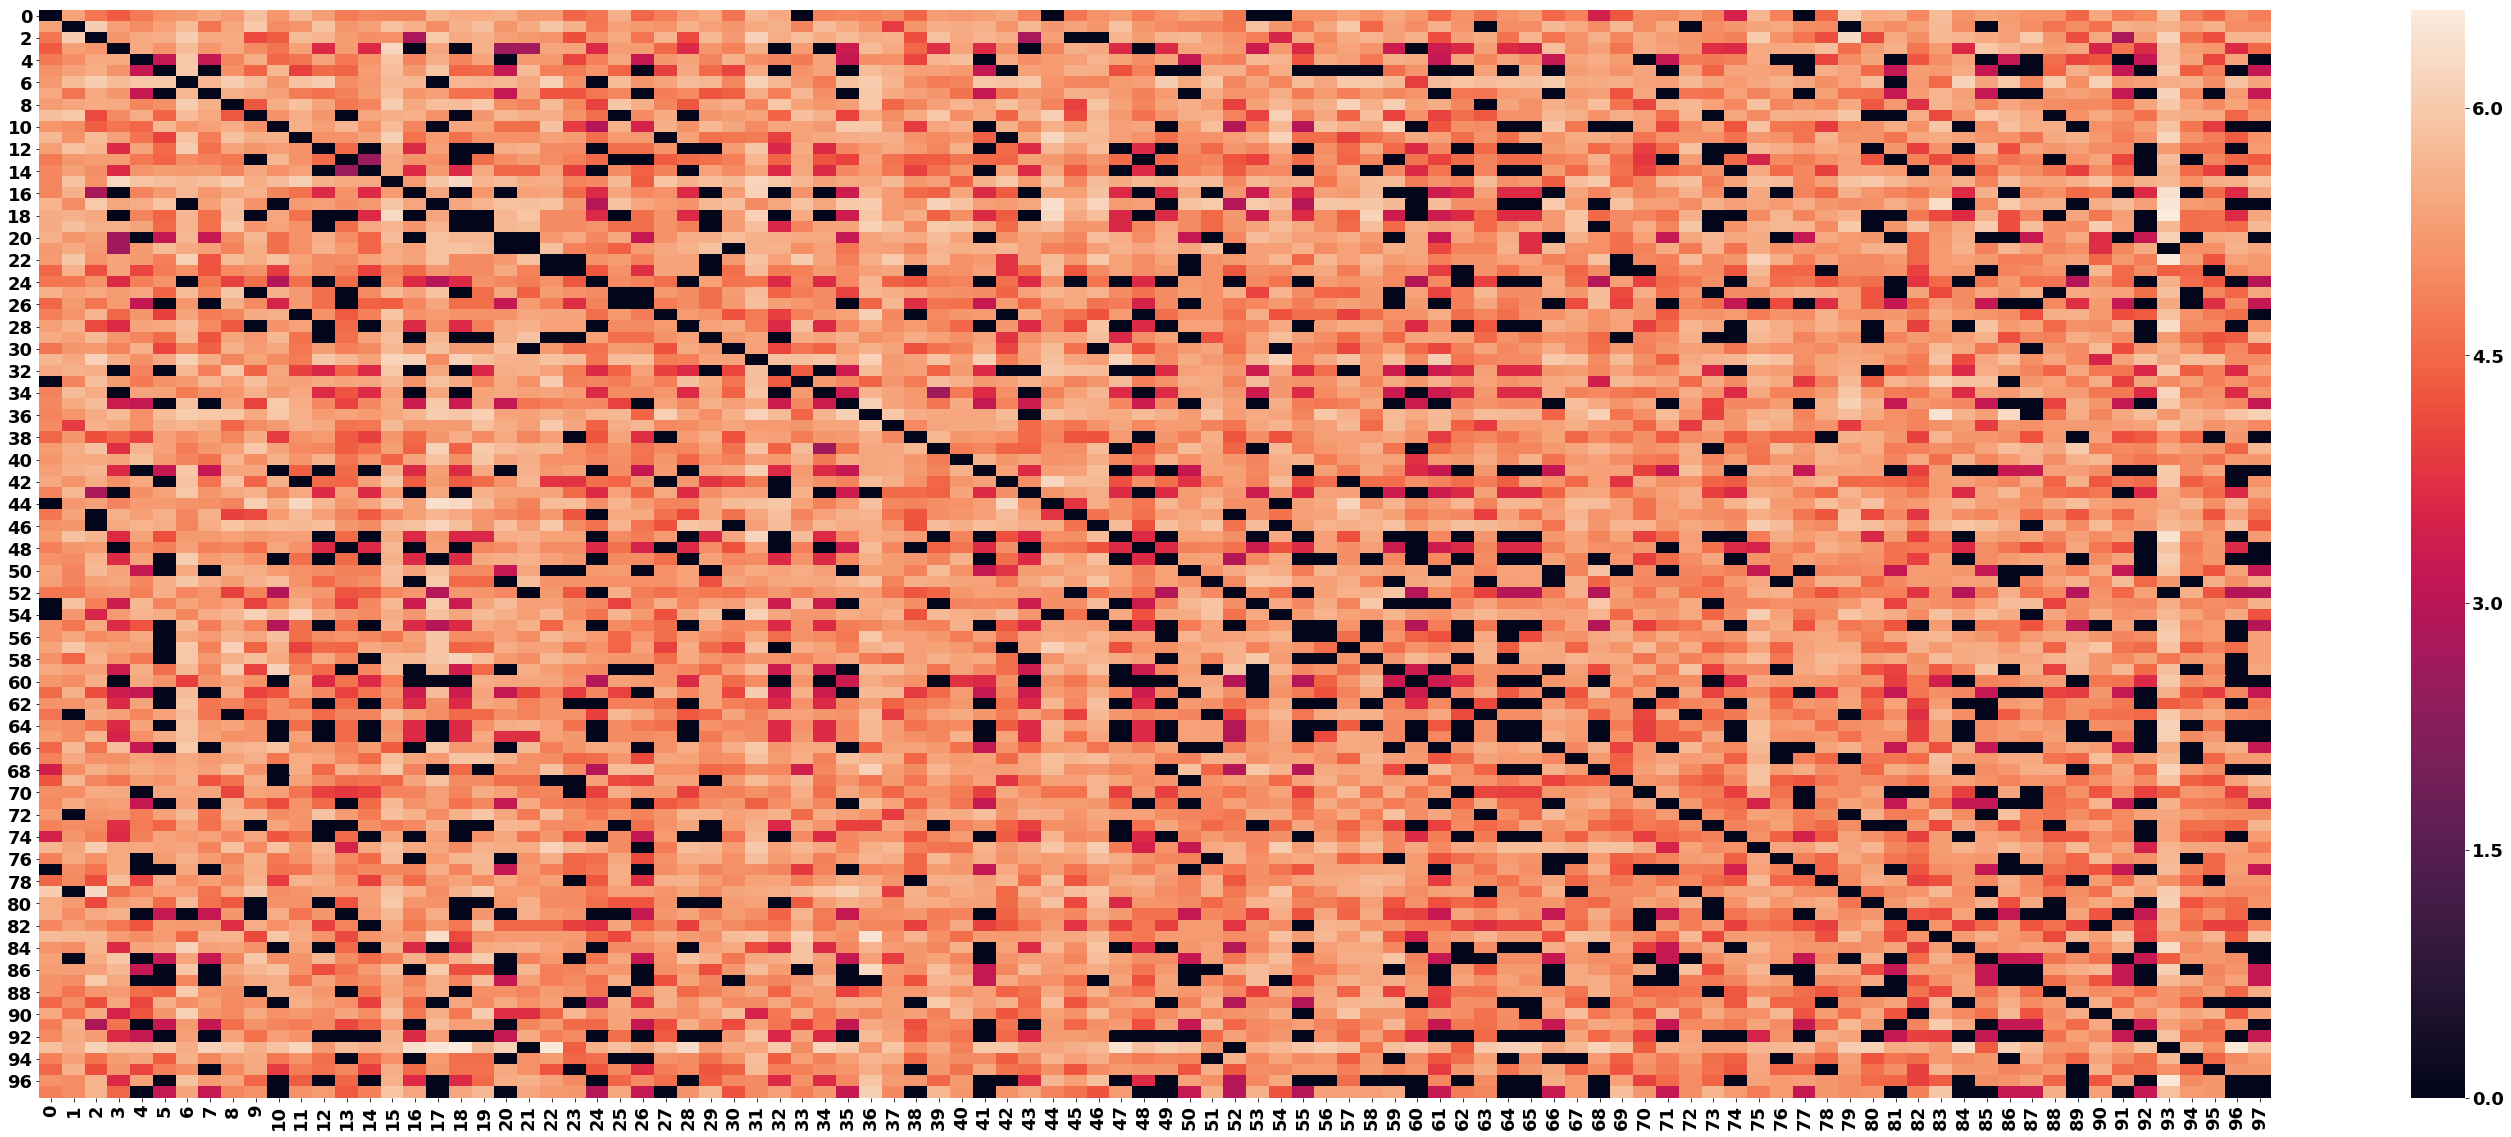

In [80]:
sns.heatmap(minimum_distance_matrix)

In [81]:
group_keywords = minimum_distance_keyword.groupby(minimum_distance_clusters).apply(lambda df: df.values.flatten())

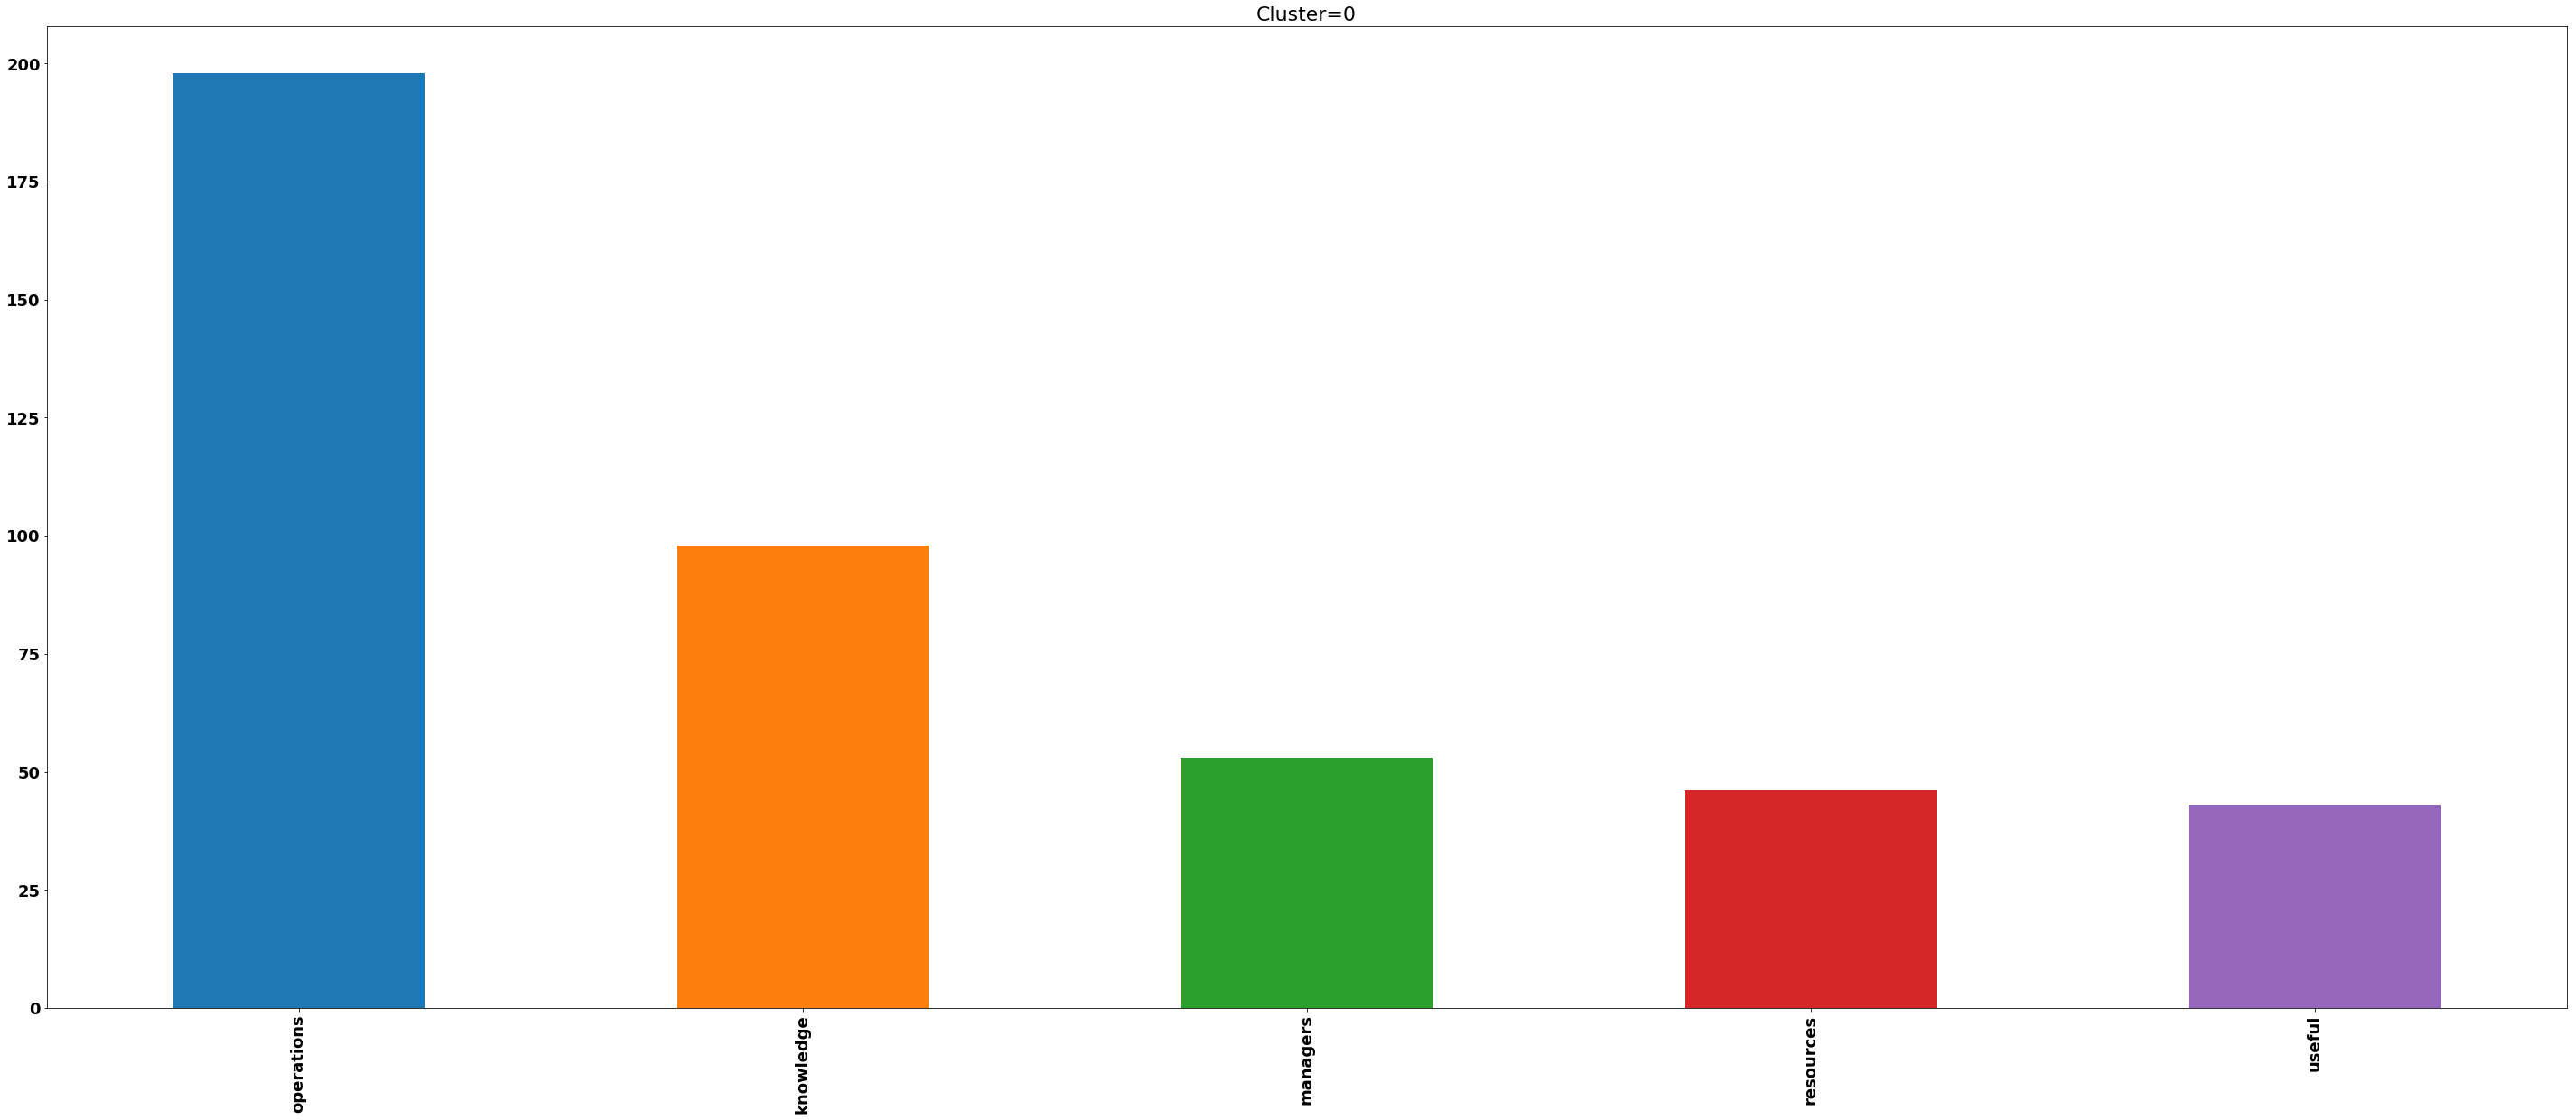

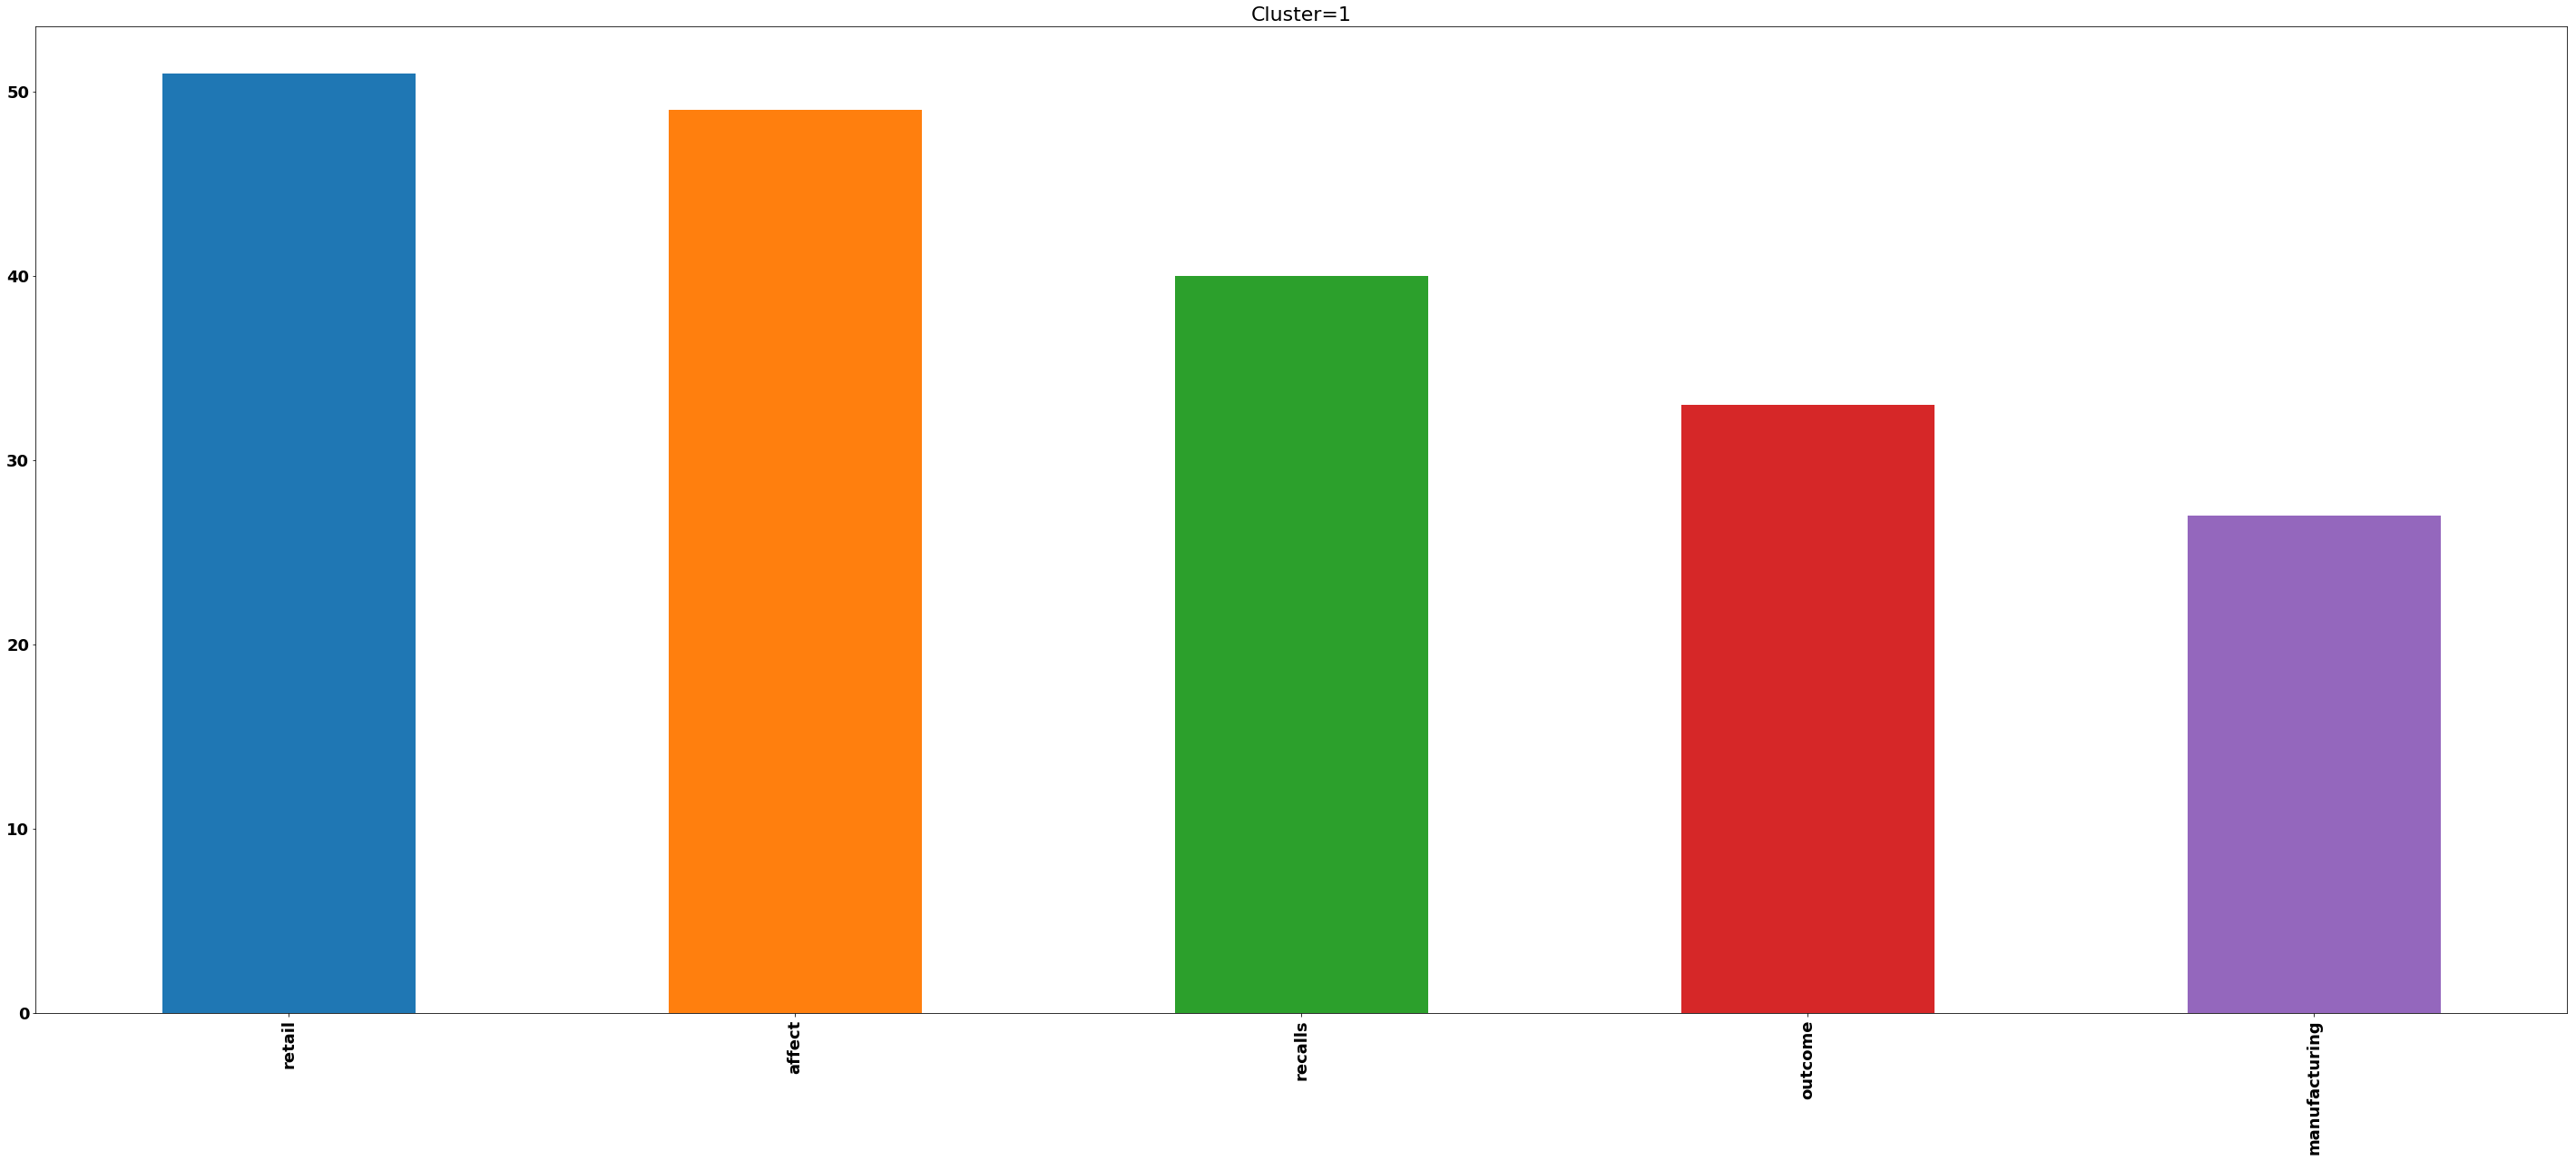

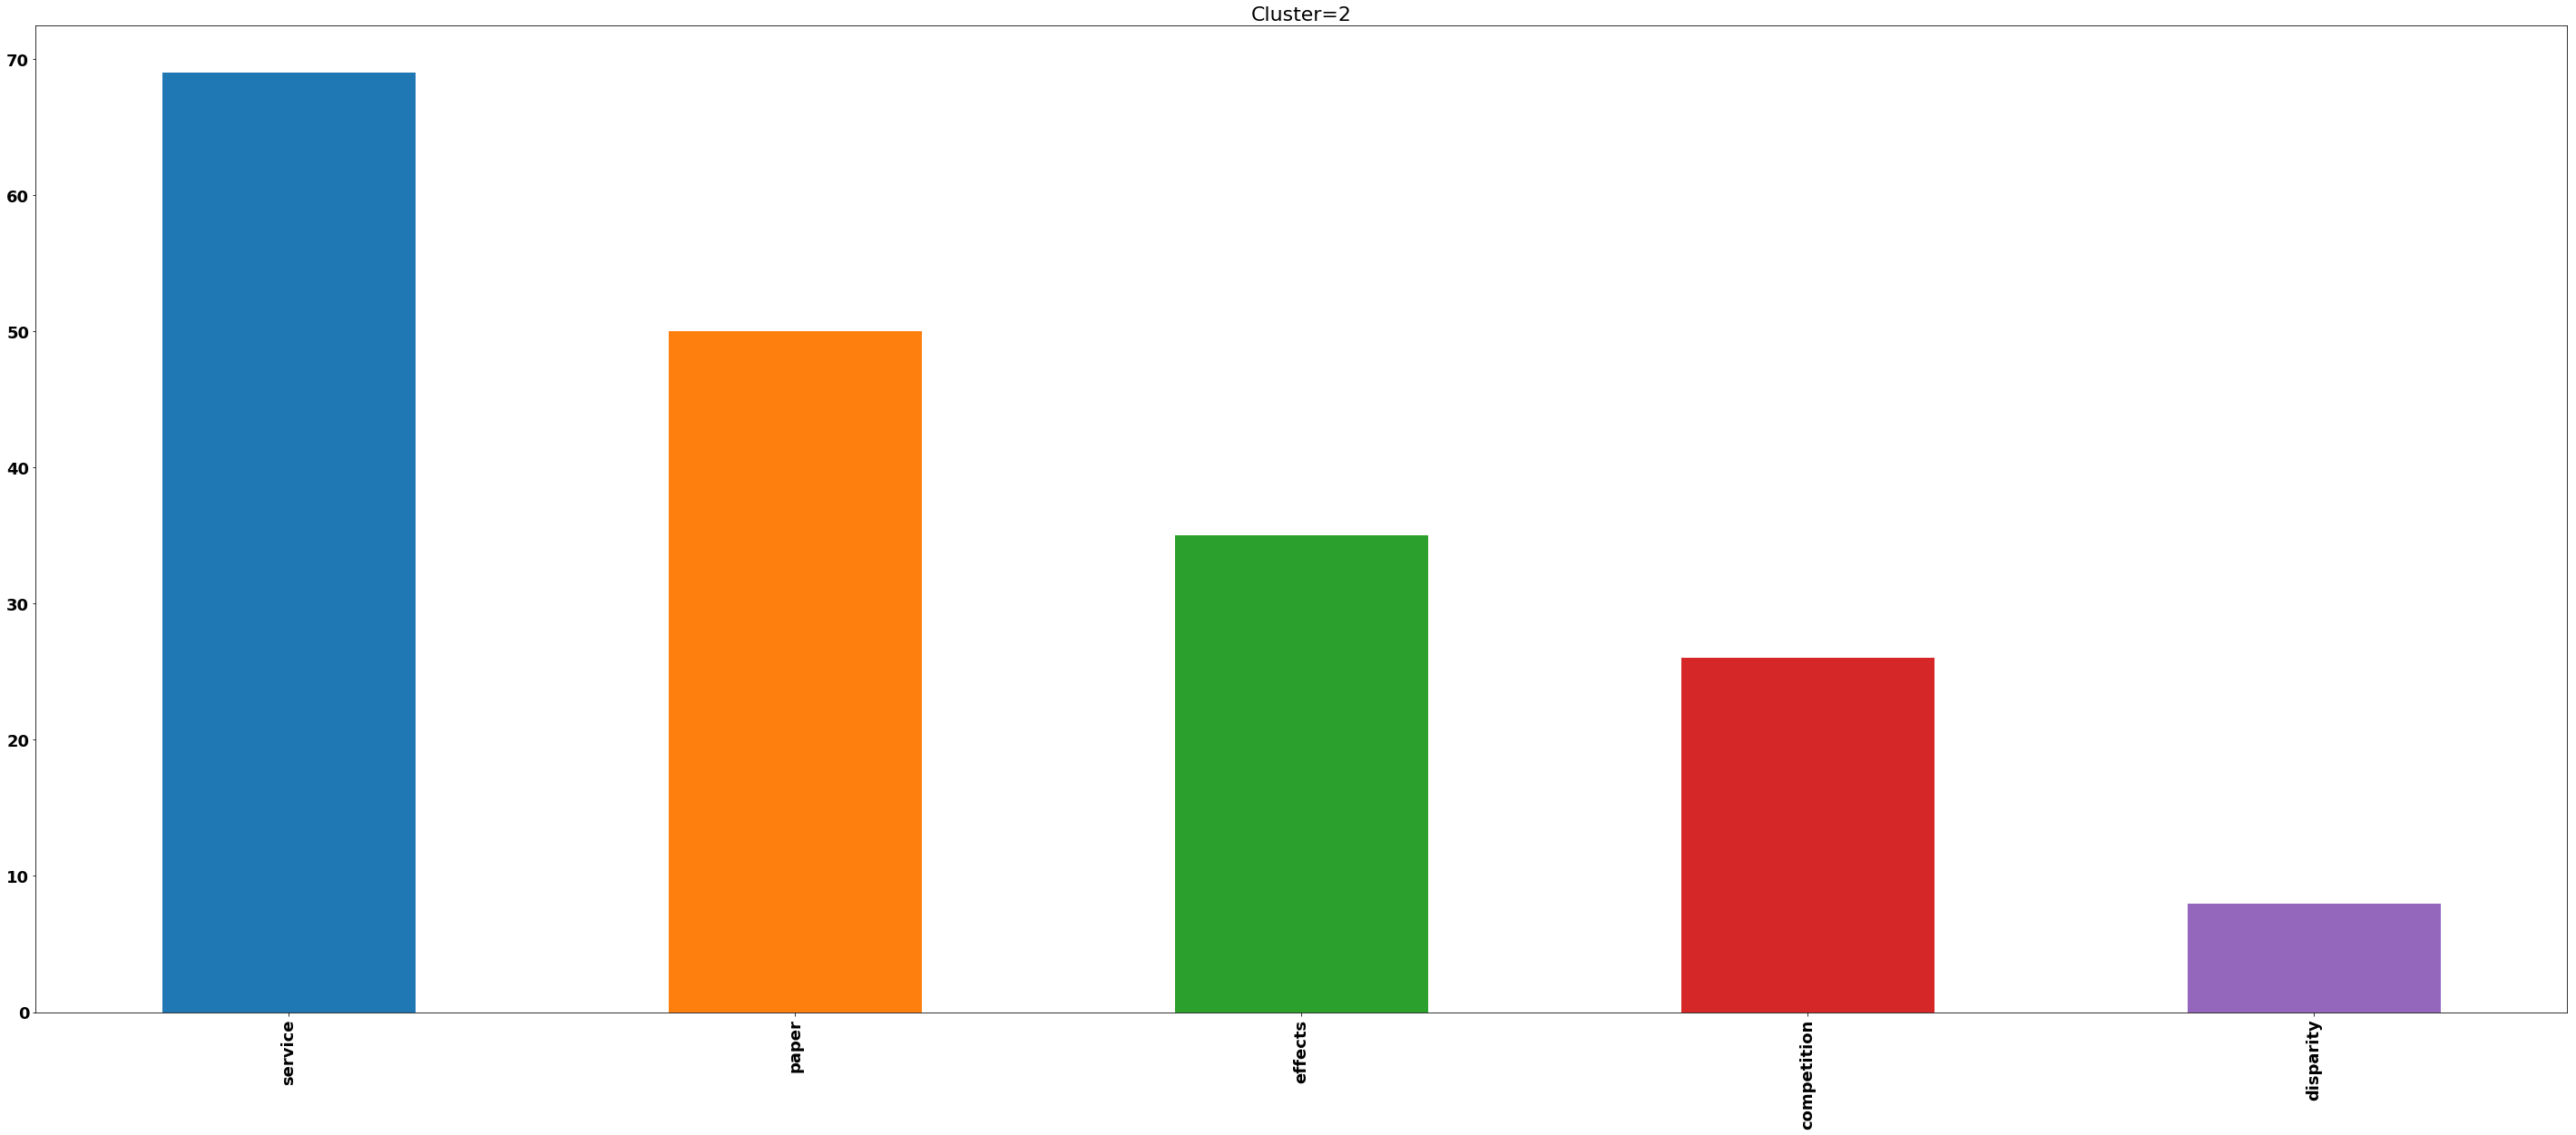

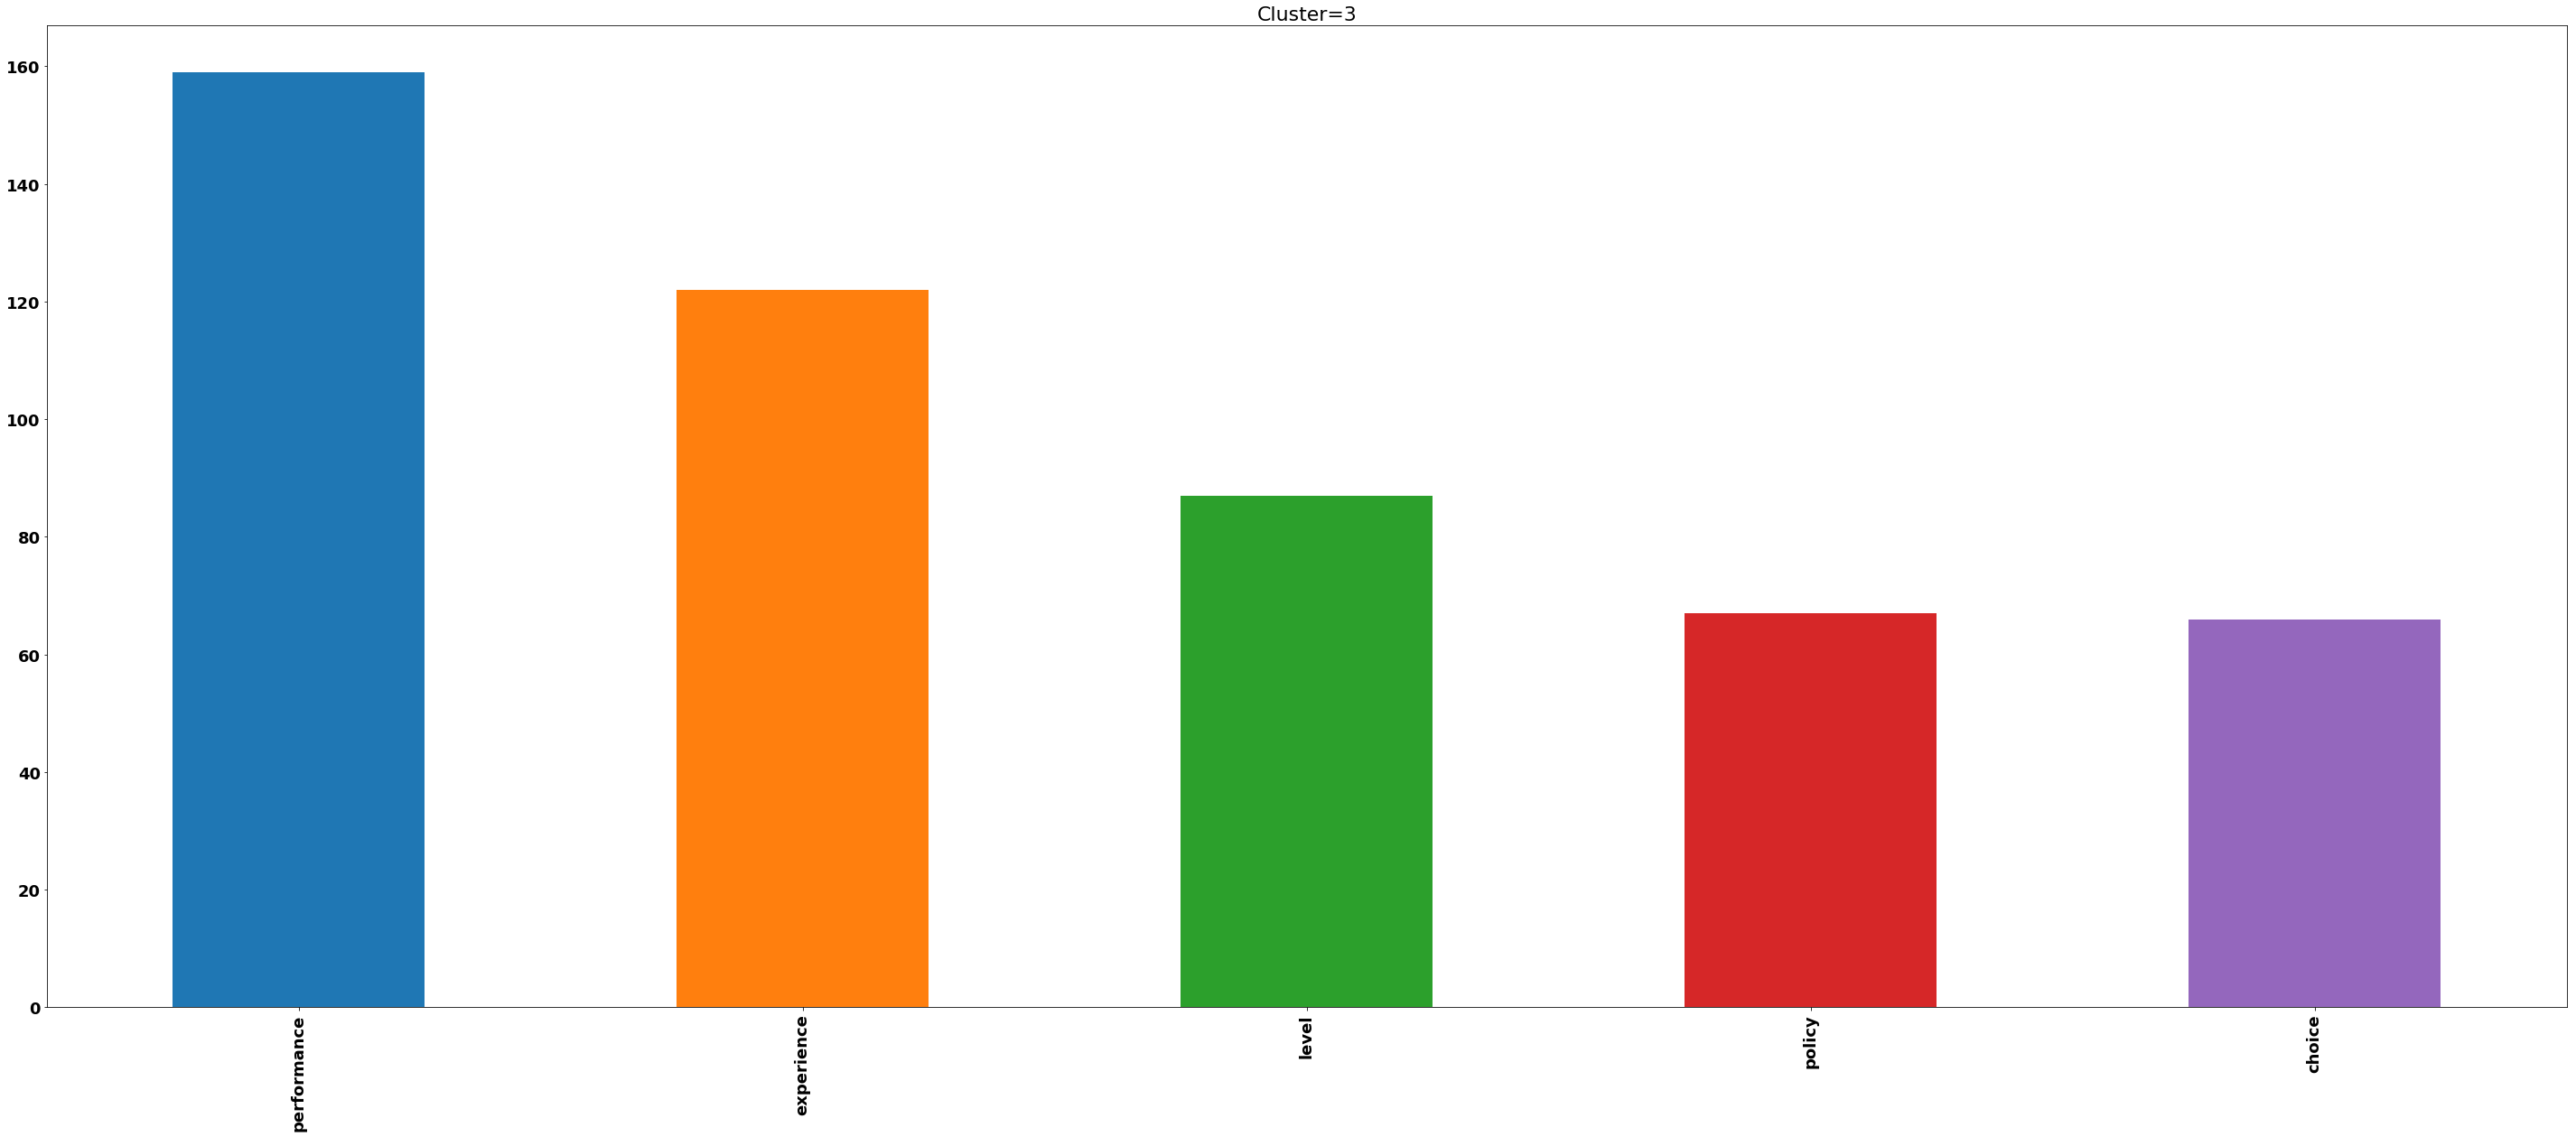

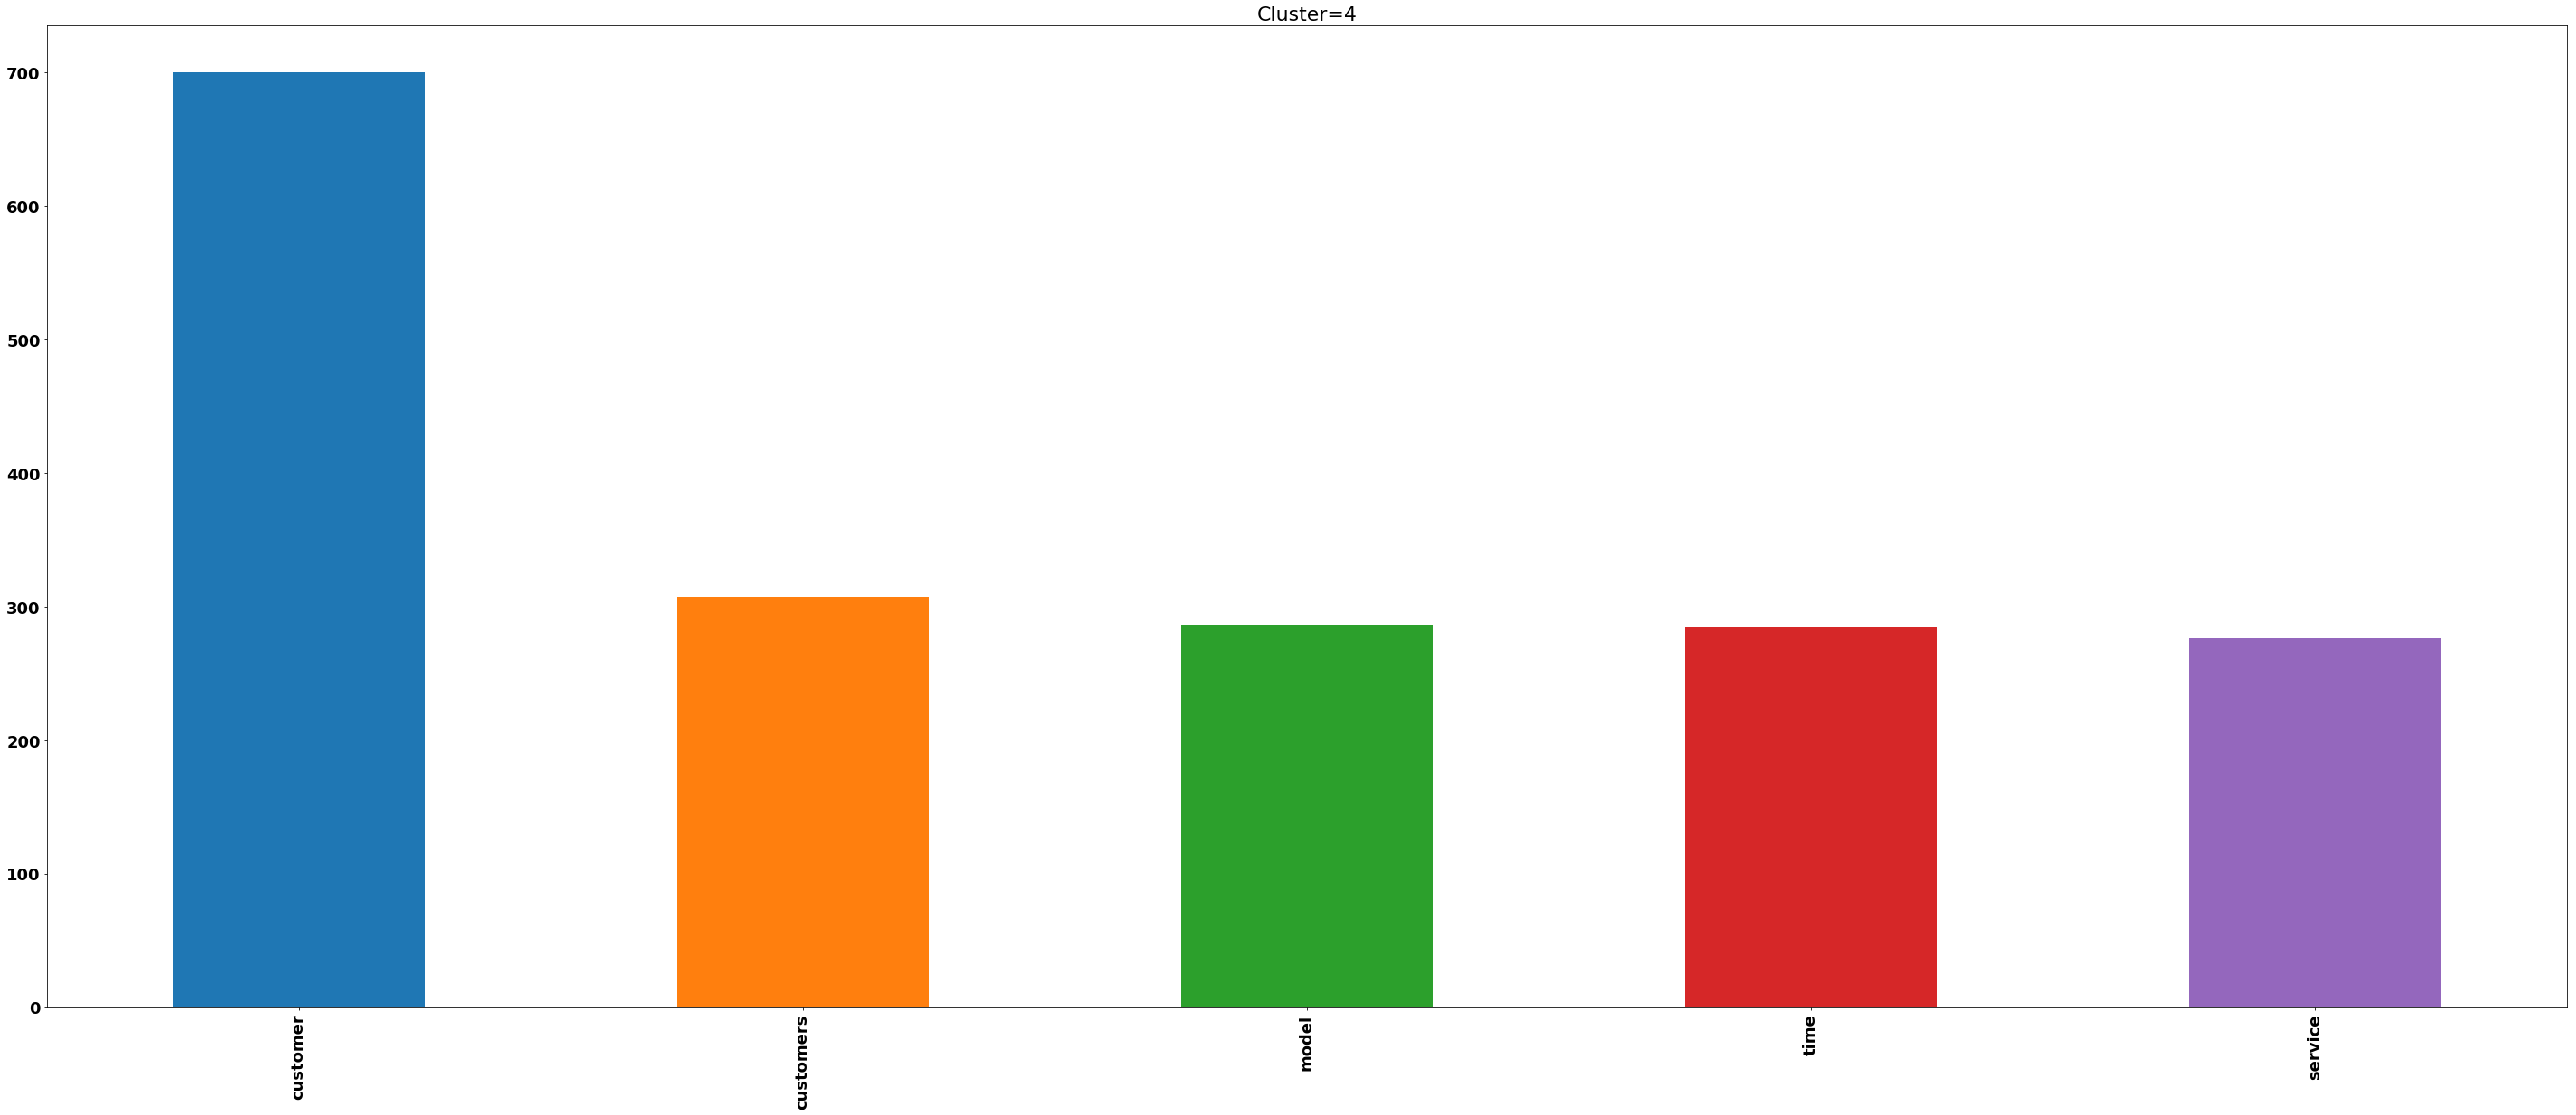

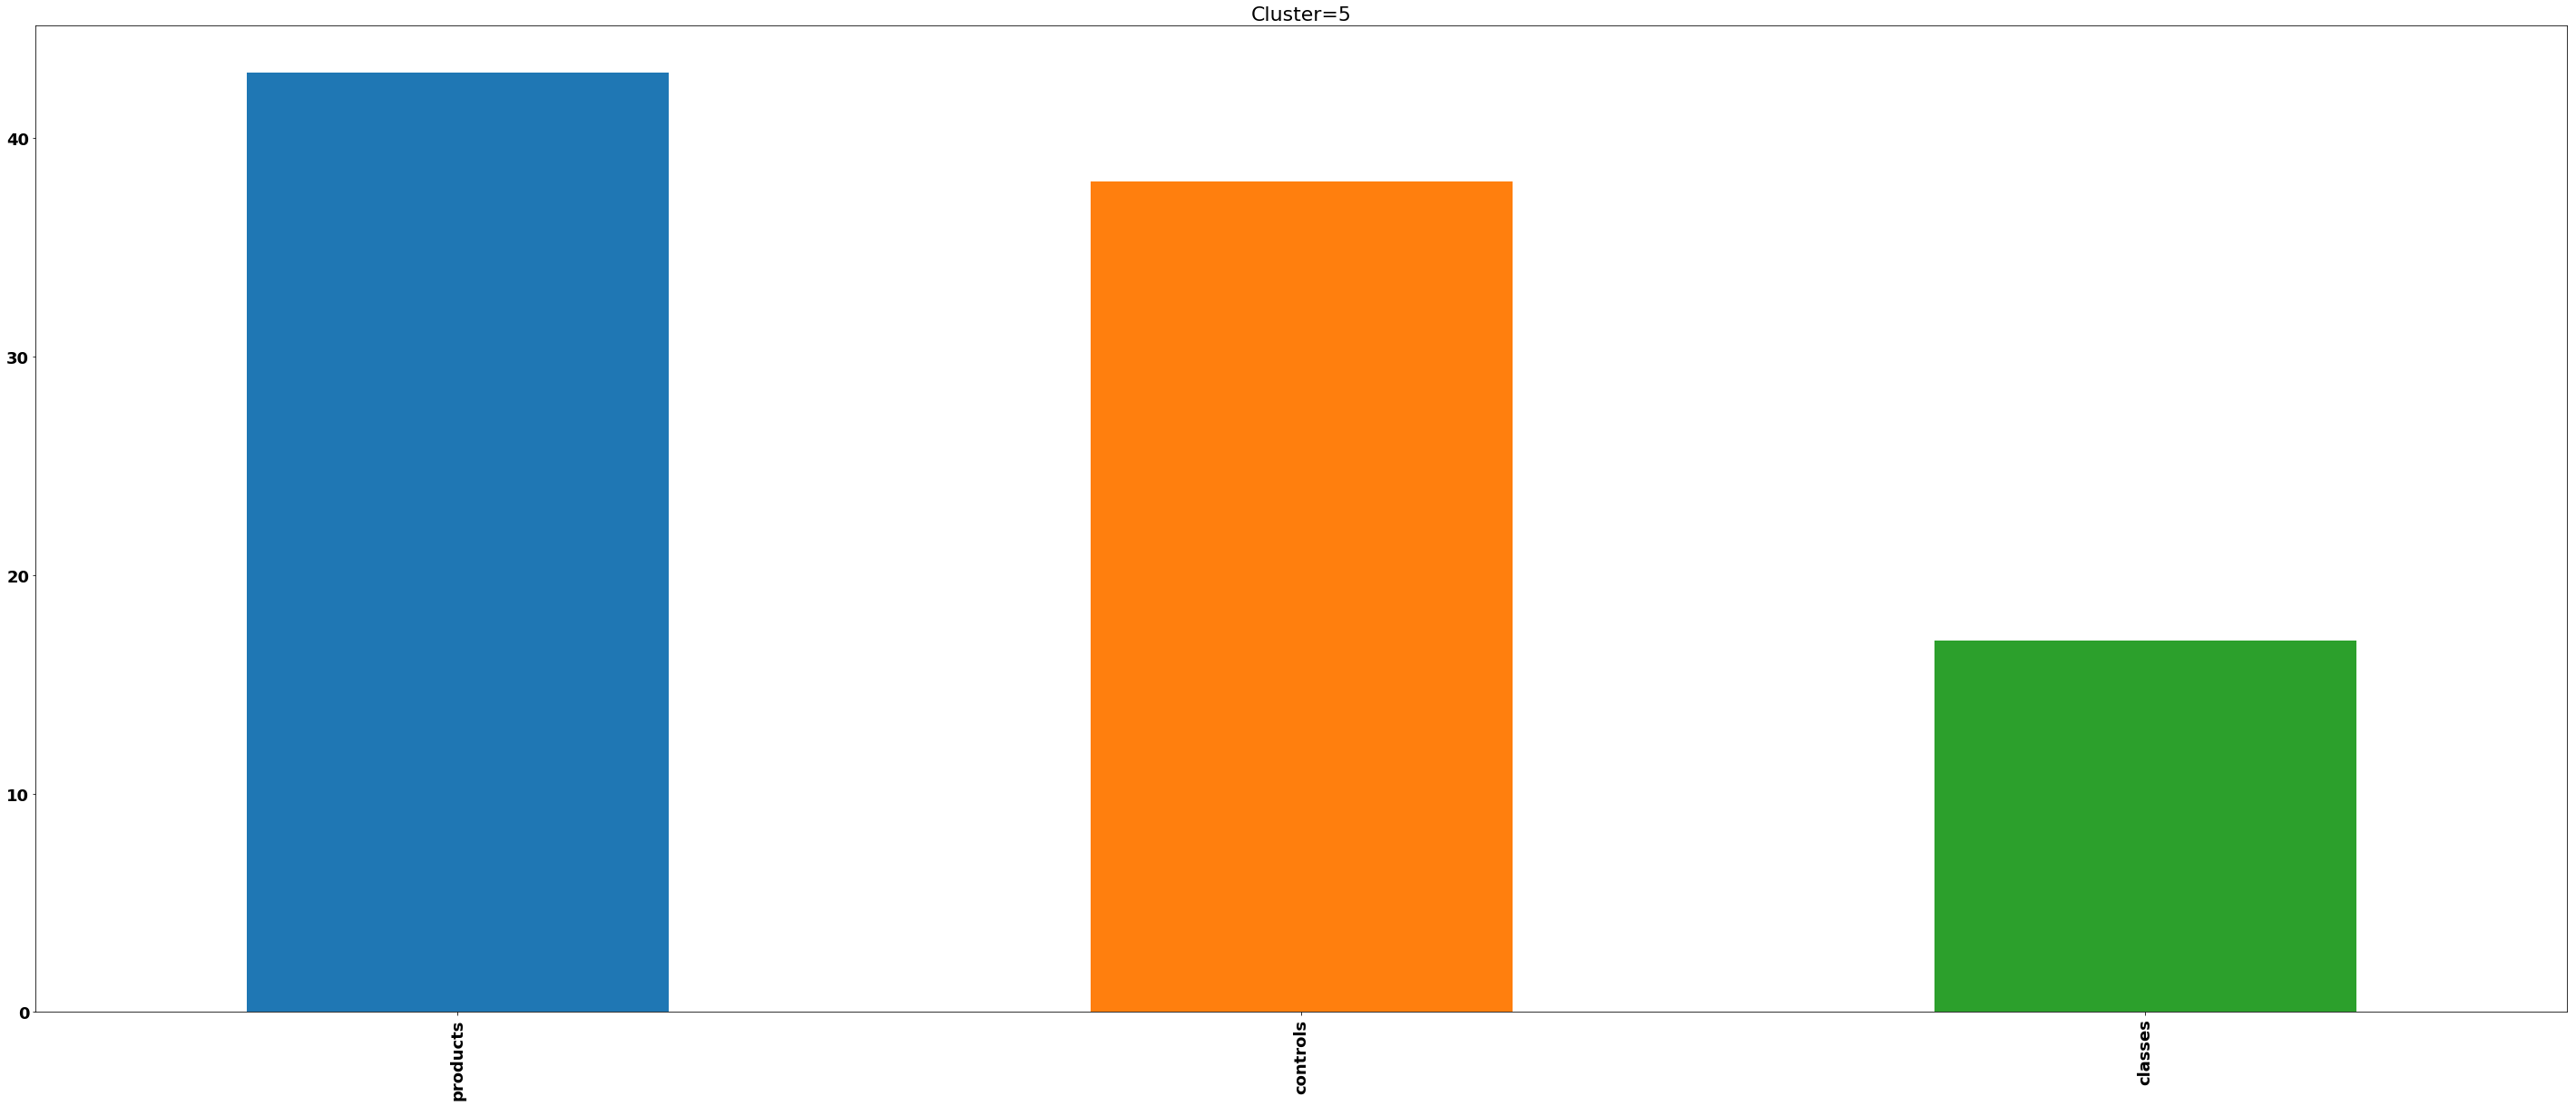

In [82]:
for i, group in enumerate(group_keywords):
    top_keywords = pd.value_counts(group).head(5)
    plt.title(f'Cluster={i}')
    top_keywords.plot.bar()
    plt.show()

### Maximum Distance Clustering

In [97]:
# %%timeit -r 1

maximum_distance_matrix, maximum_distance_keyword = compute_abstract_space(maximum_keyword_distance)

In [98]:
def maximum_distance_clustering(n_clusters):
    return AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average').fit_predict(maximum_distance_matrix)

maximum_distance_clusters = maximum_distance_clustering(6)

In [99]:
maximum_distance_clusters

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [100]:
group_keywords = maximum_distance_keyword.groupby(maximum_distance_clusters).apply(lambda df: df.values.flatten())

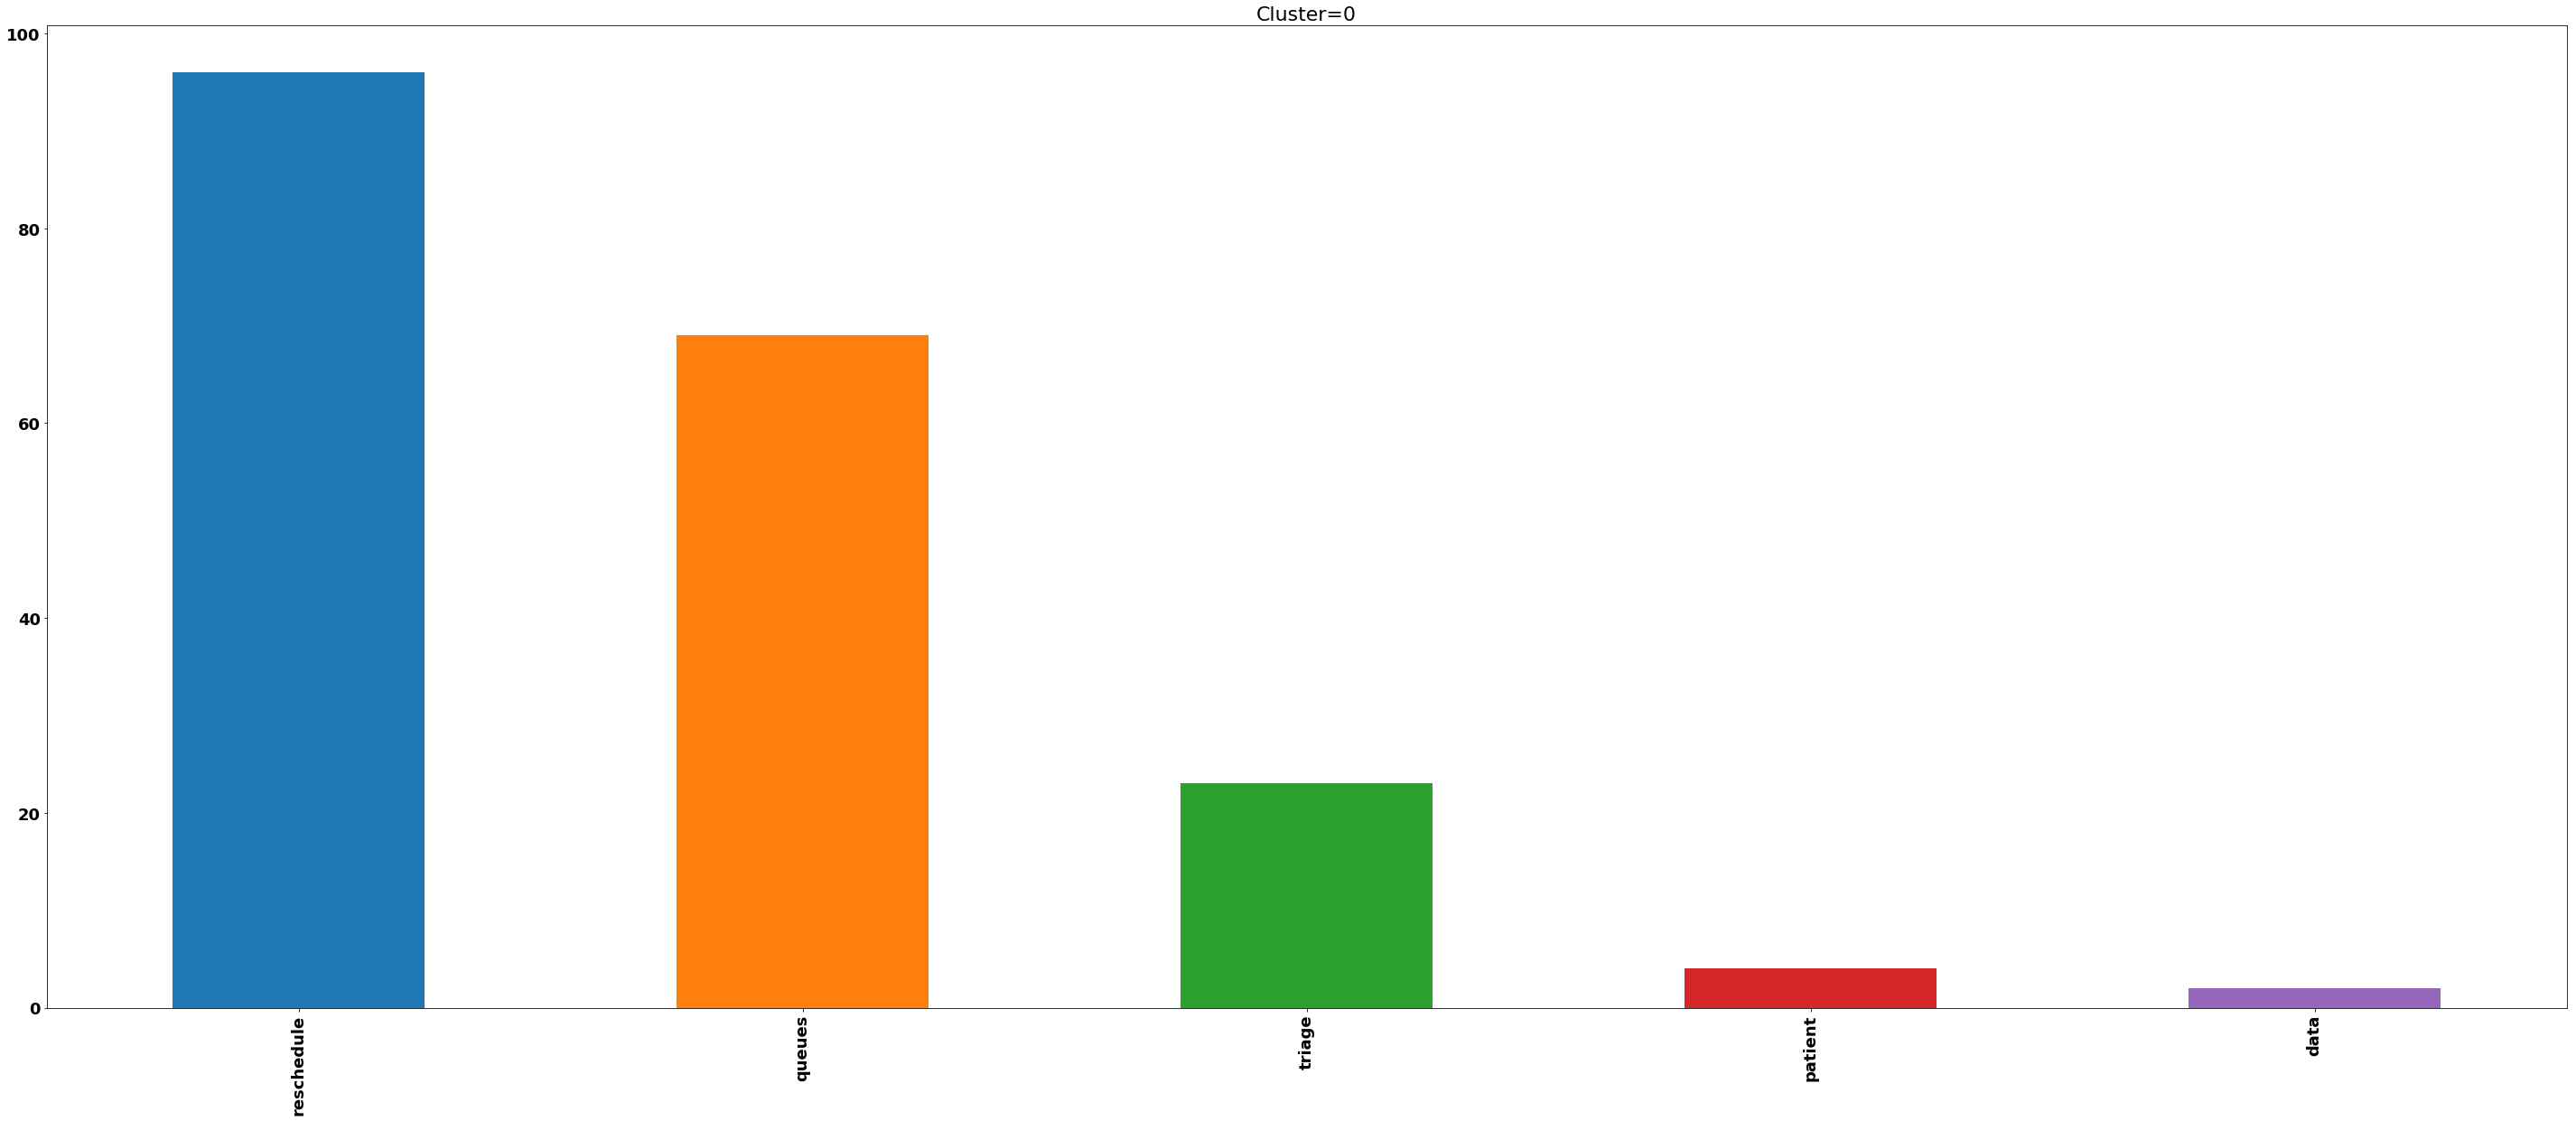

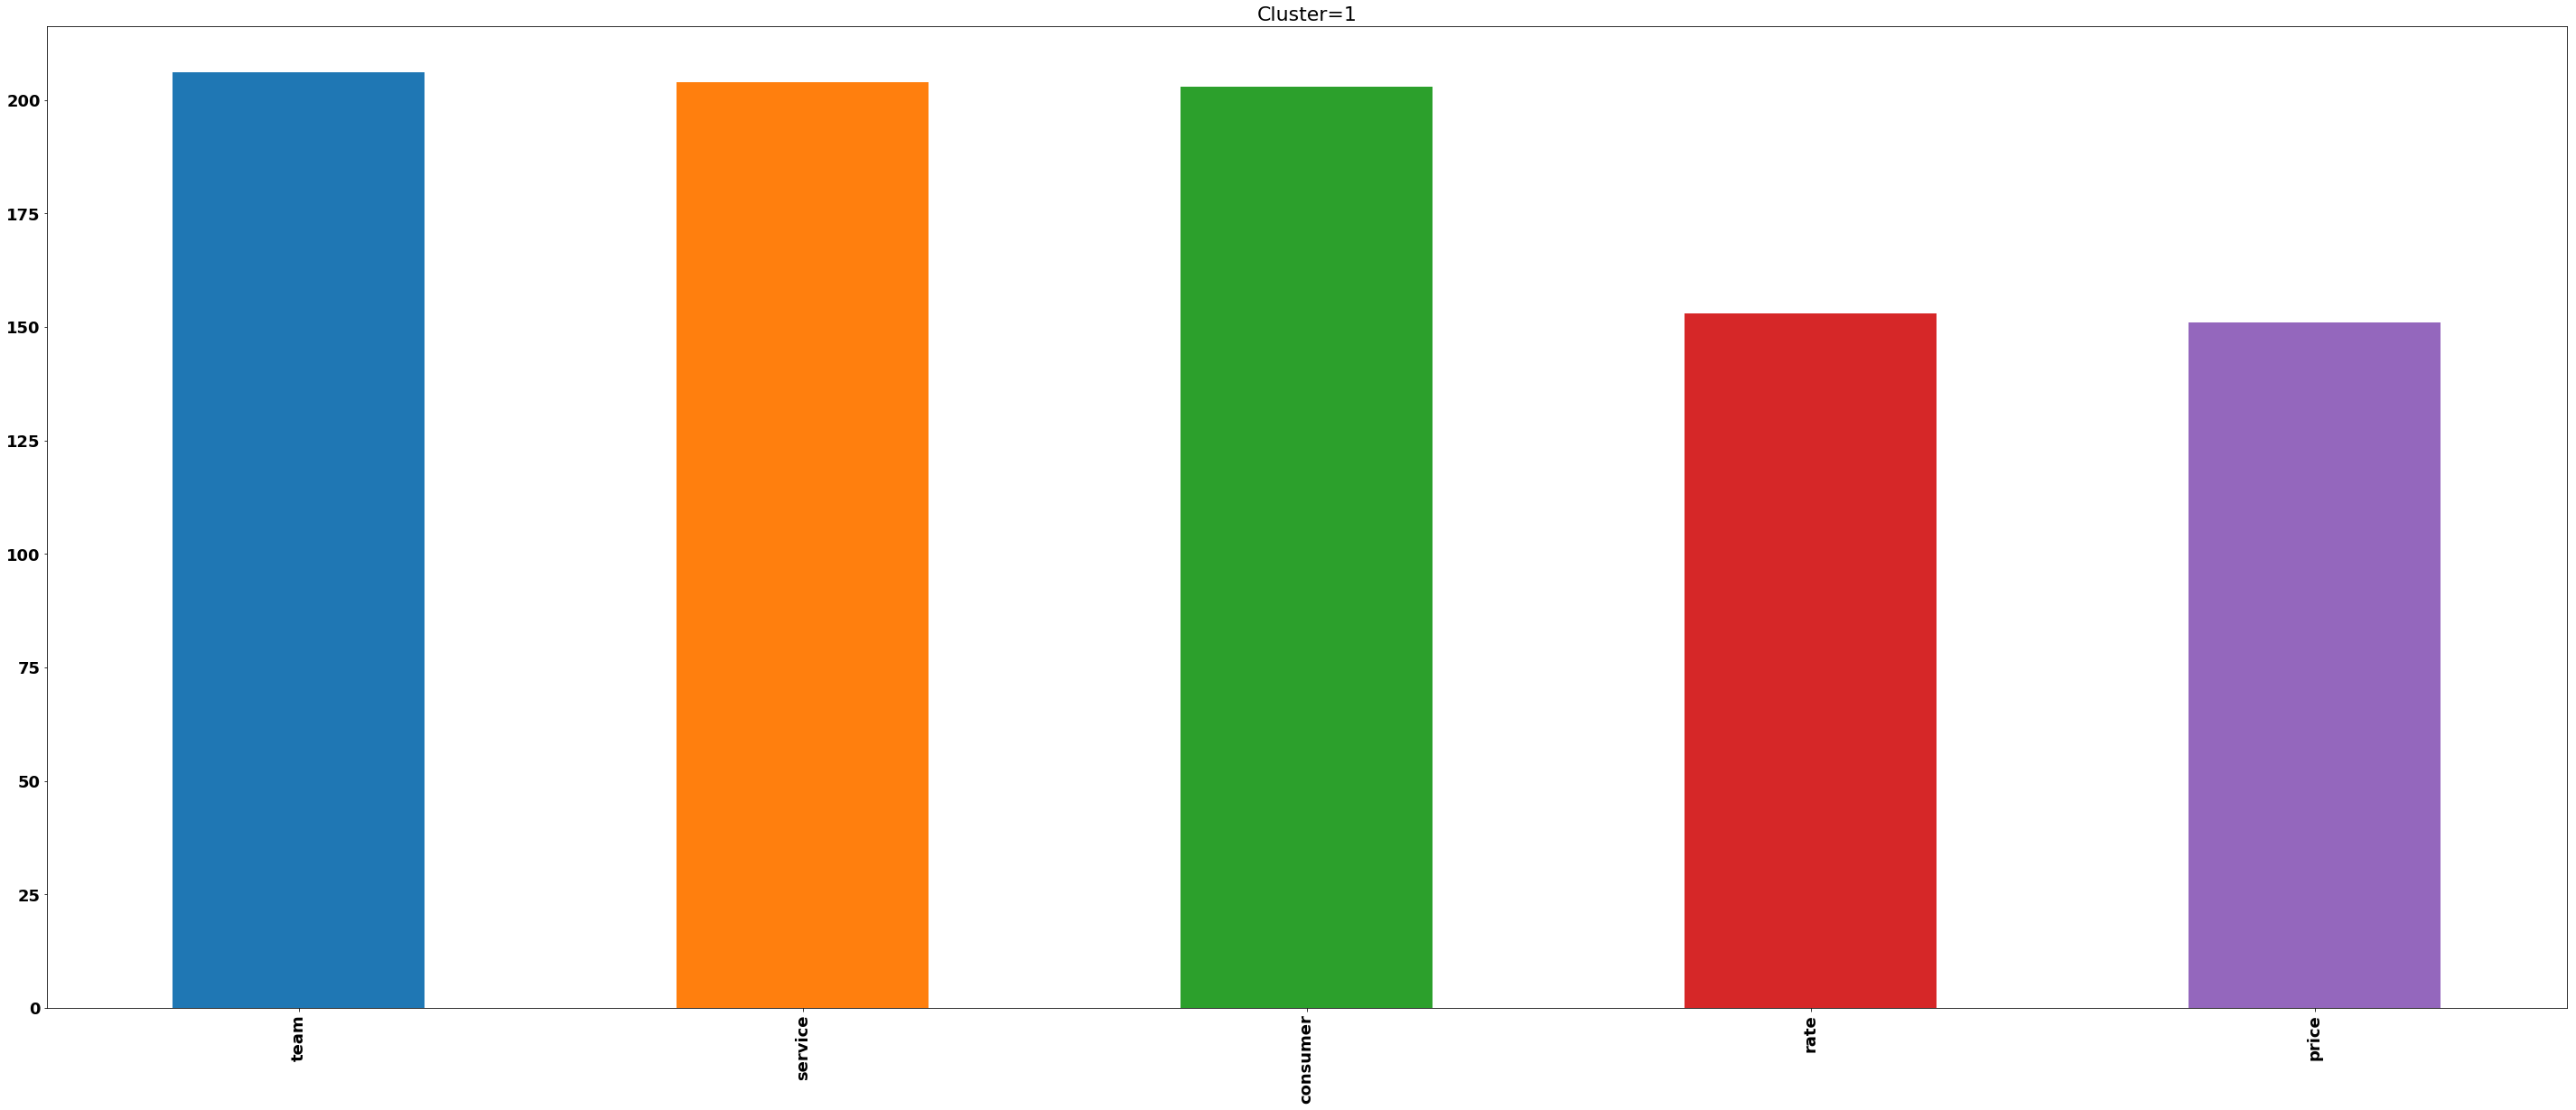

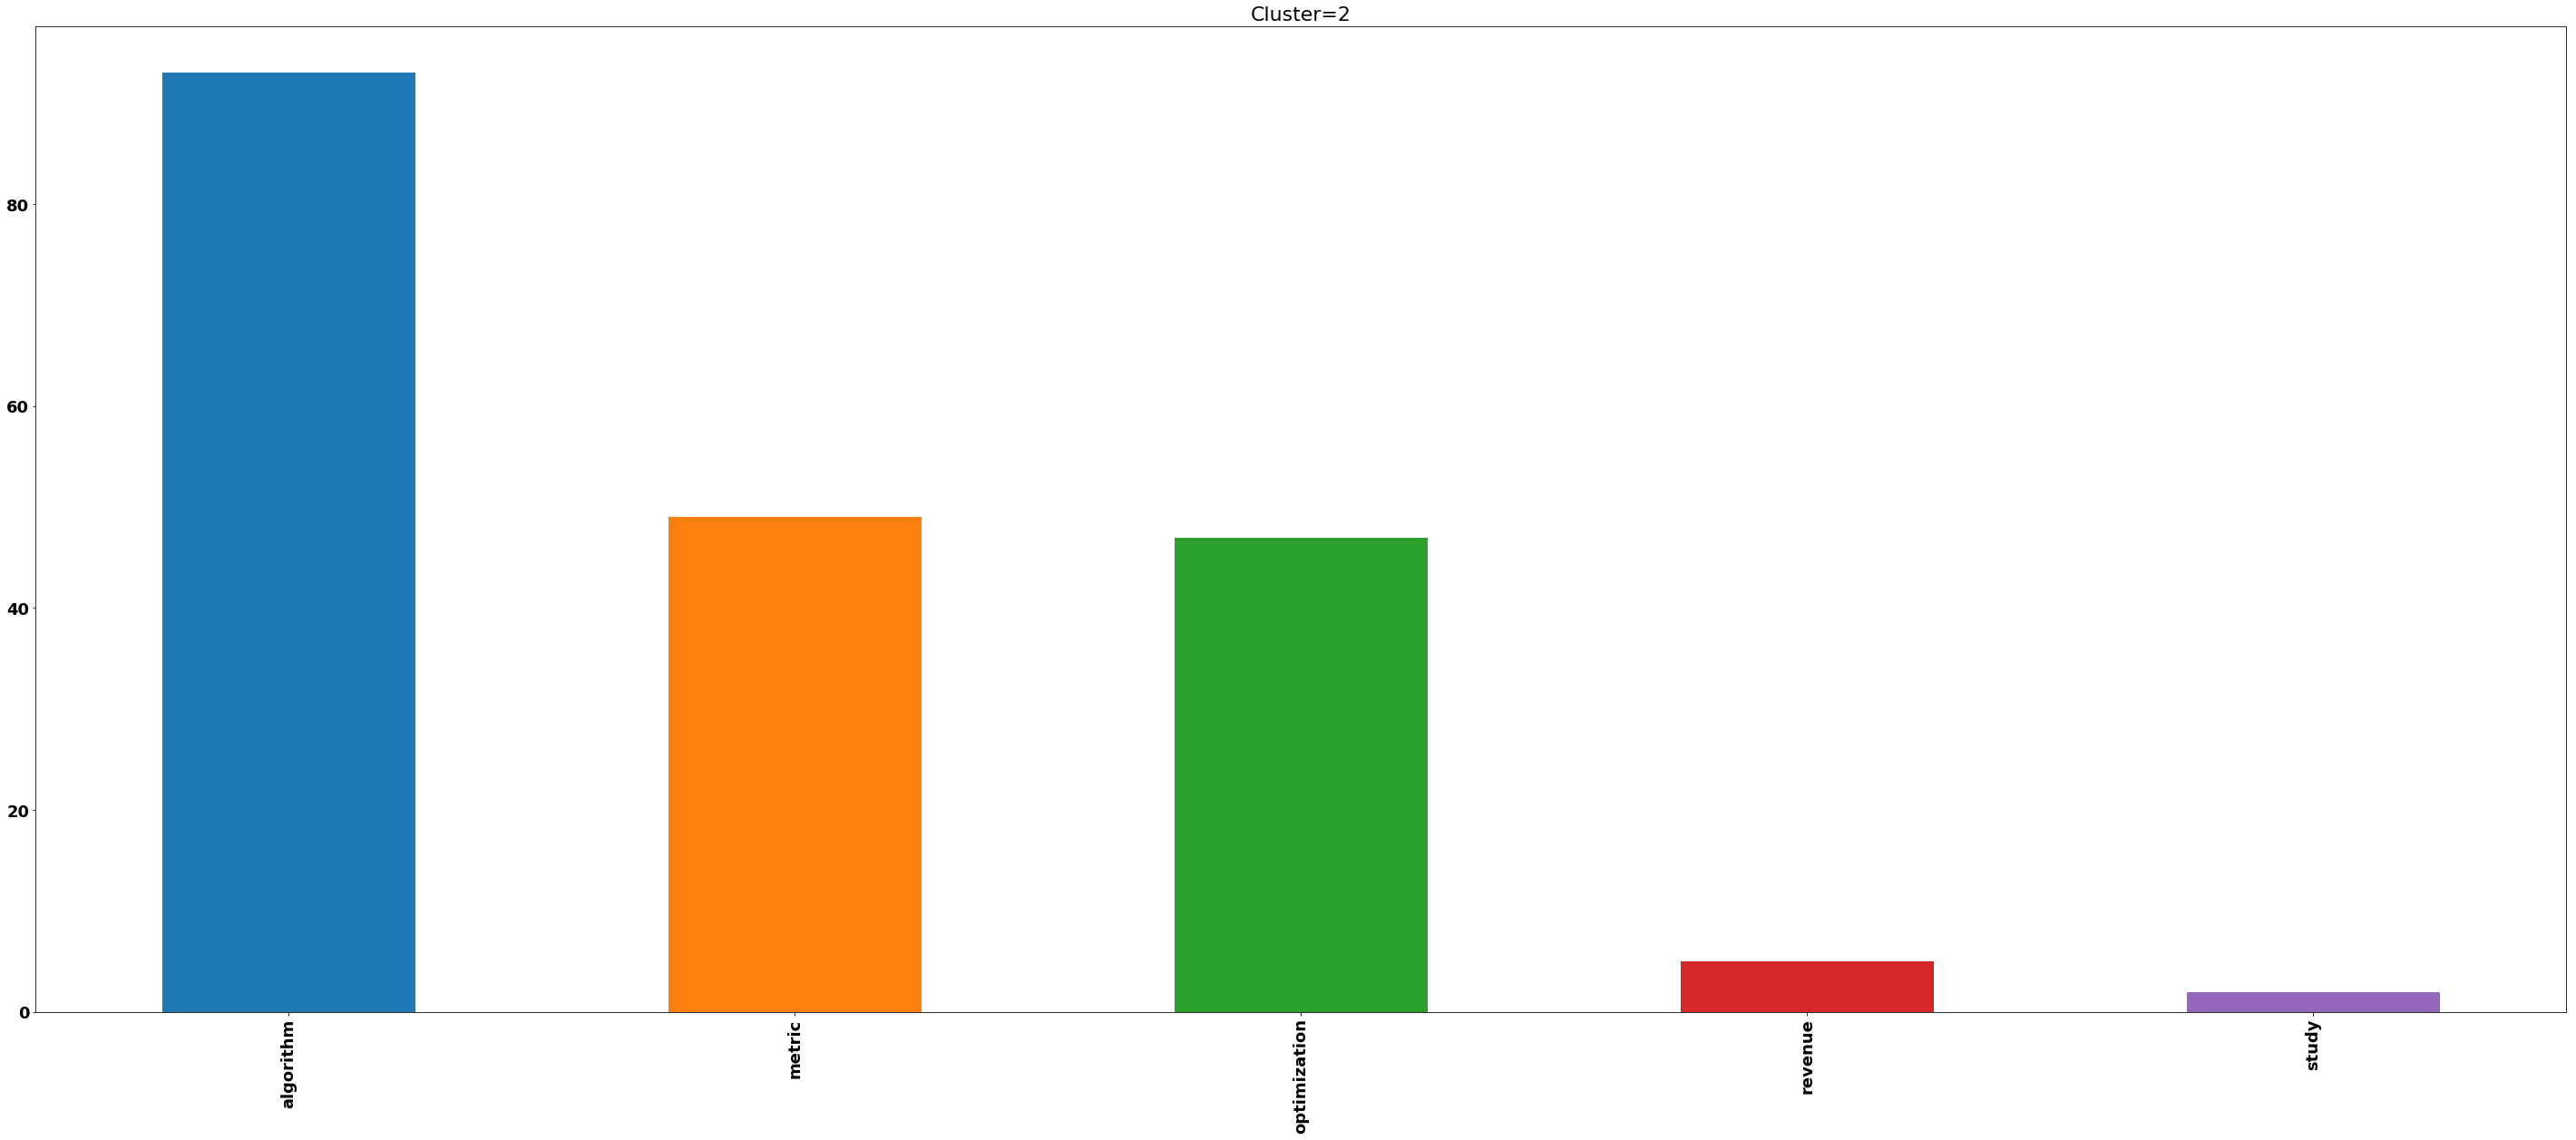

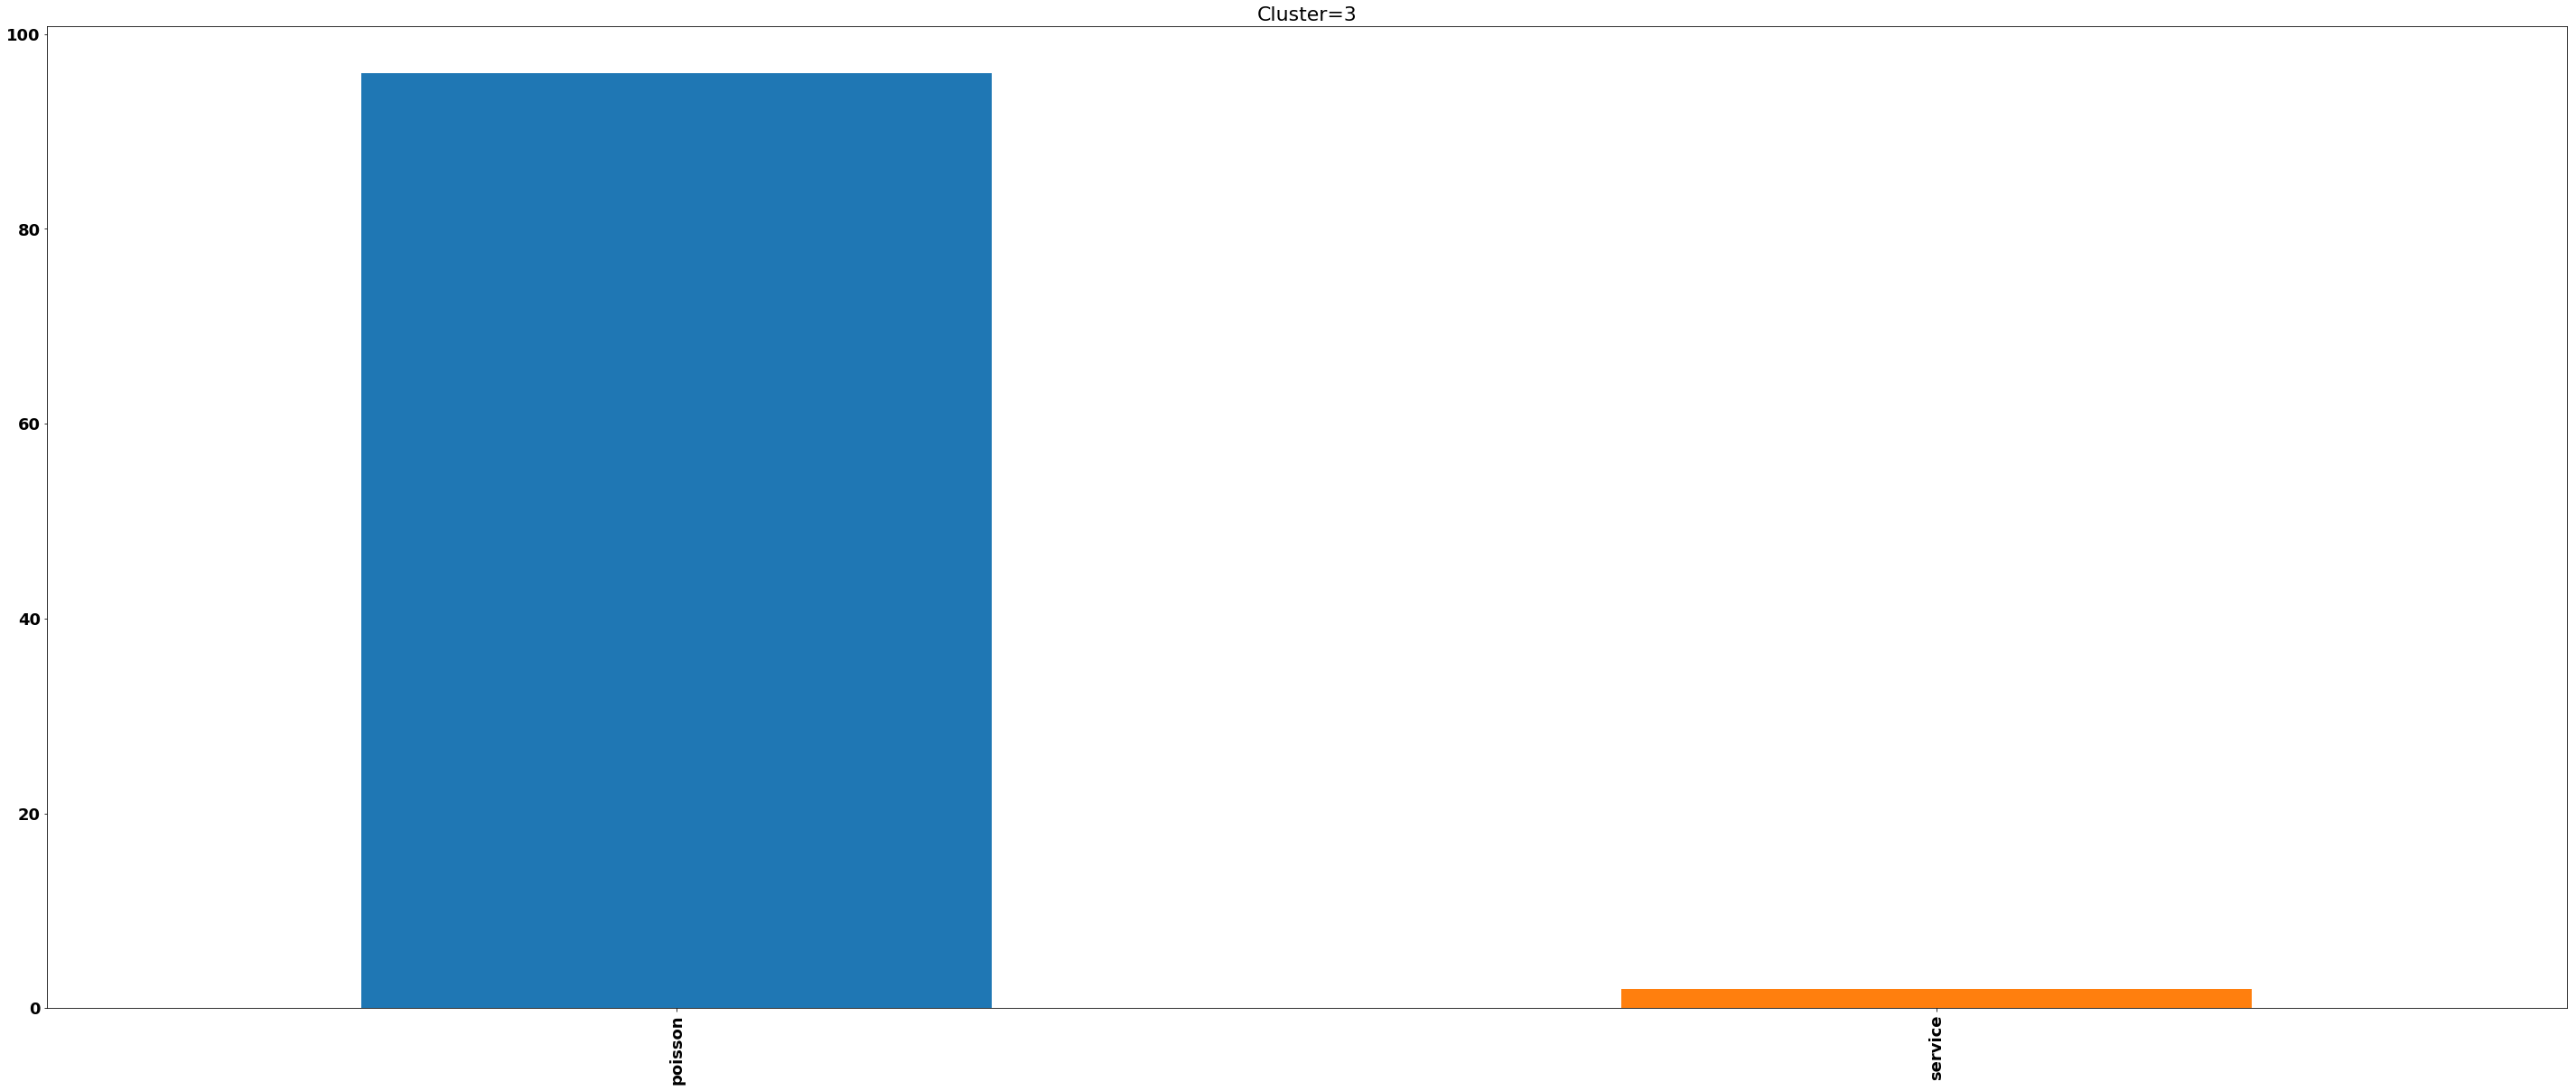

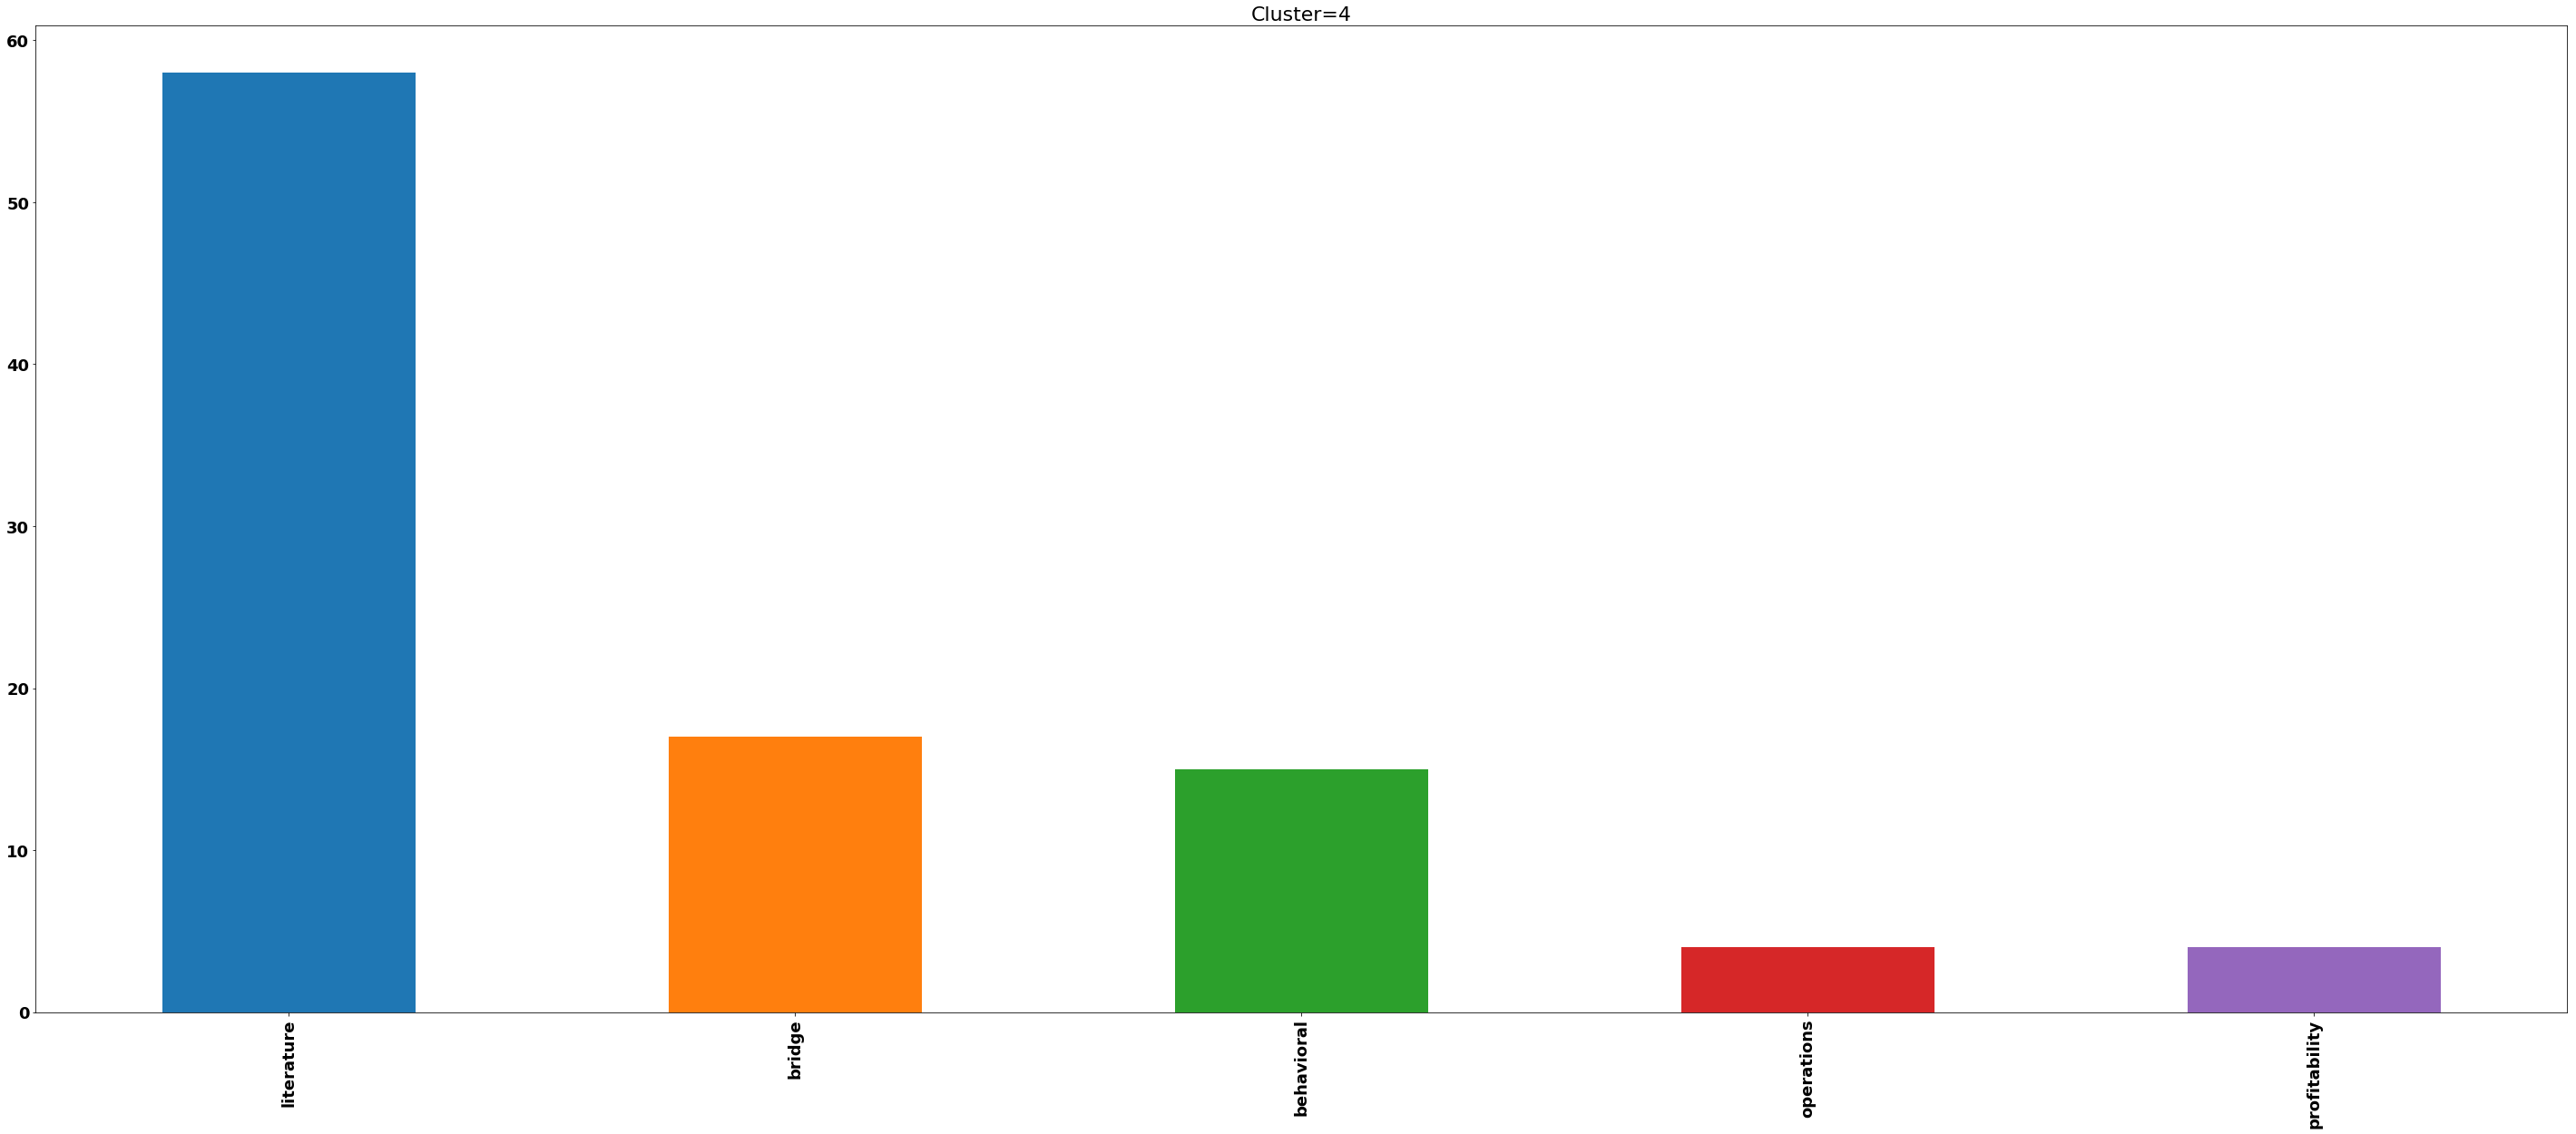

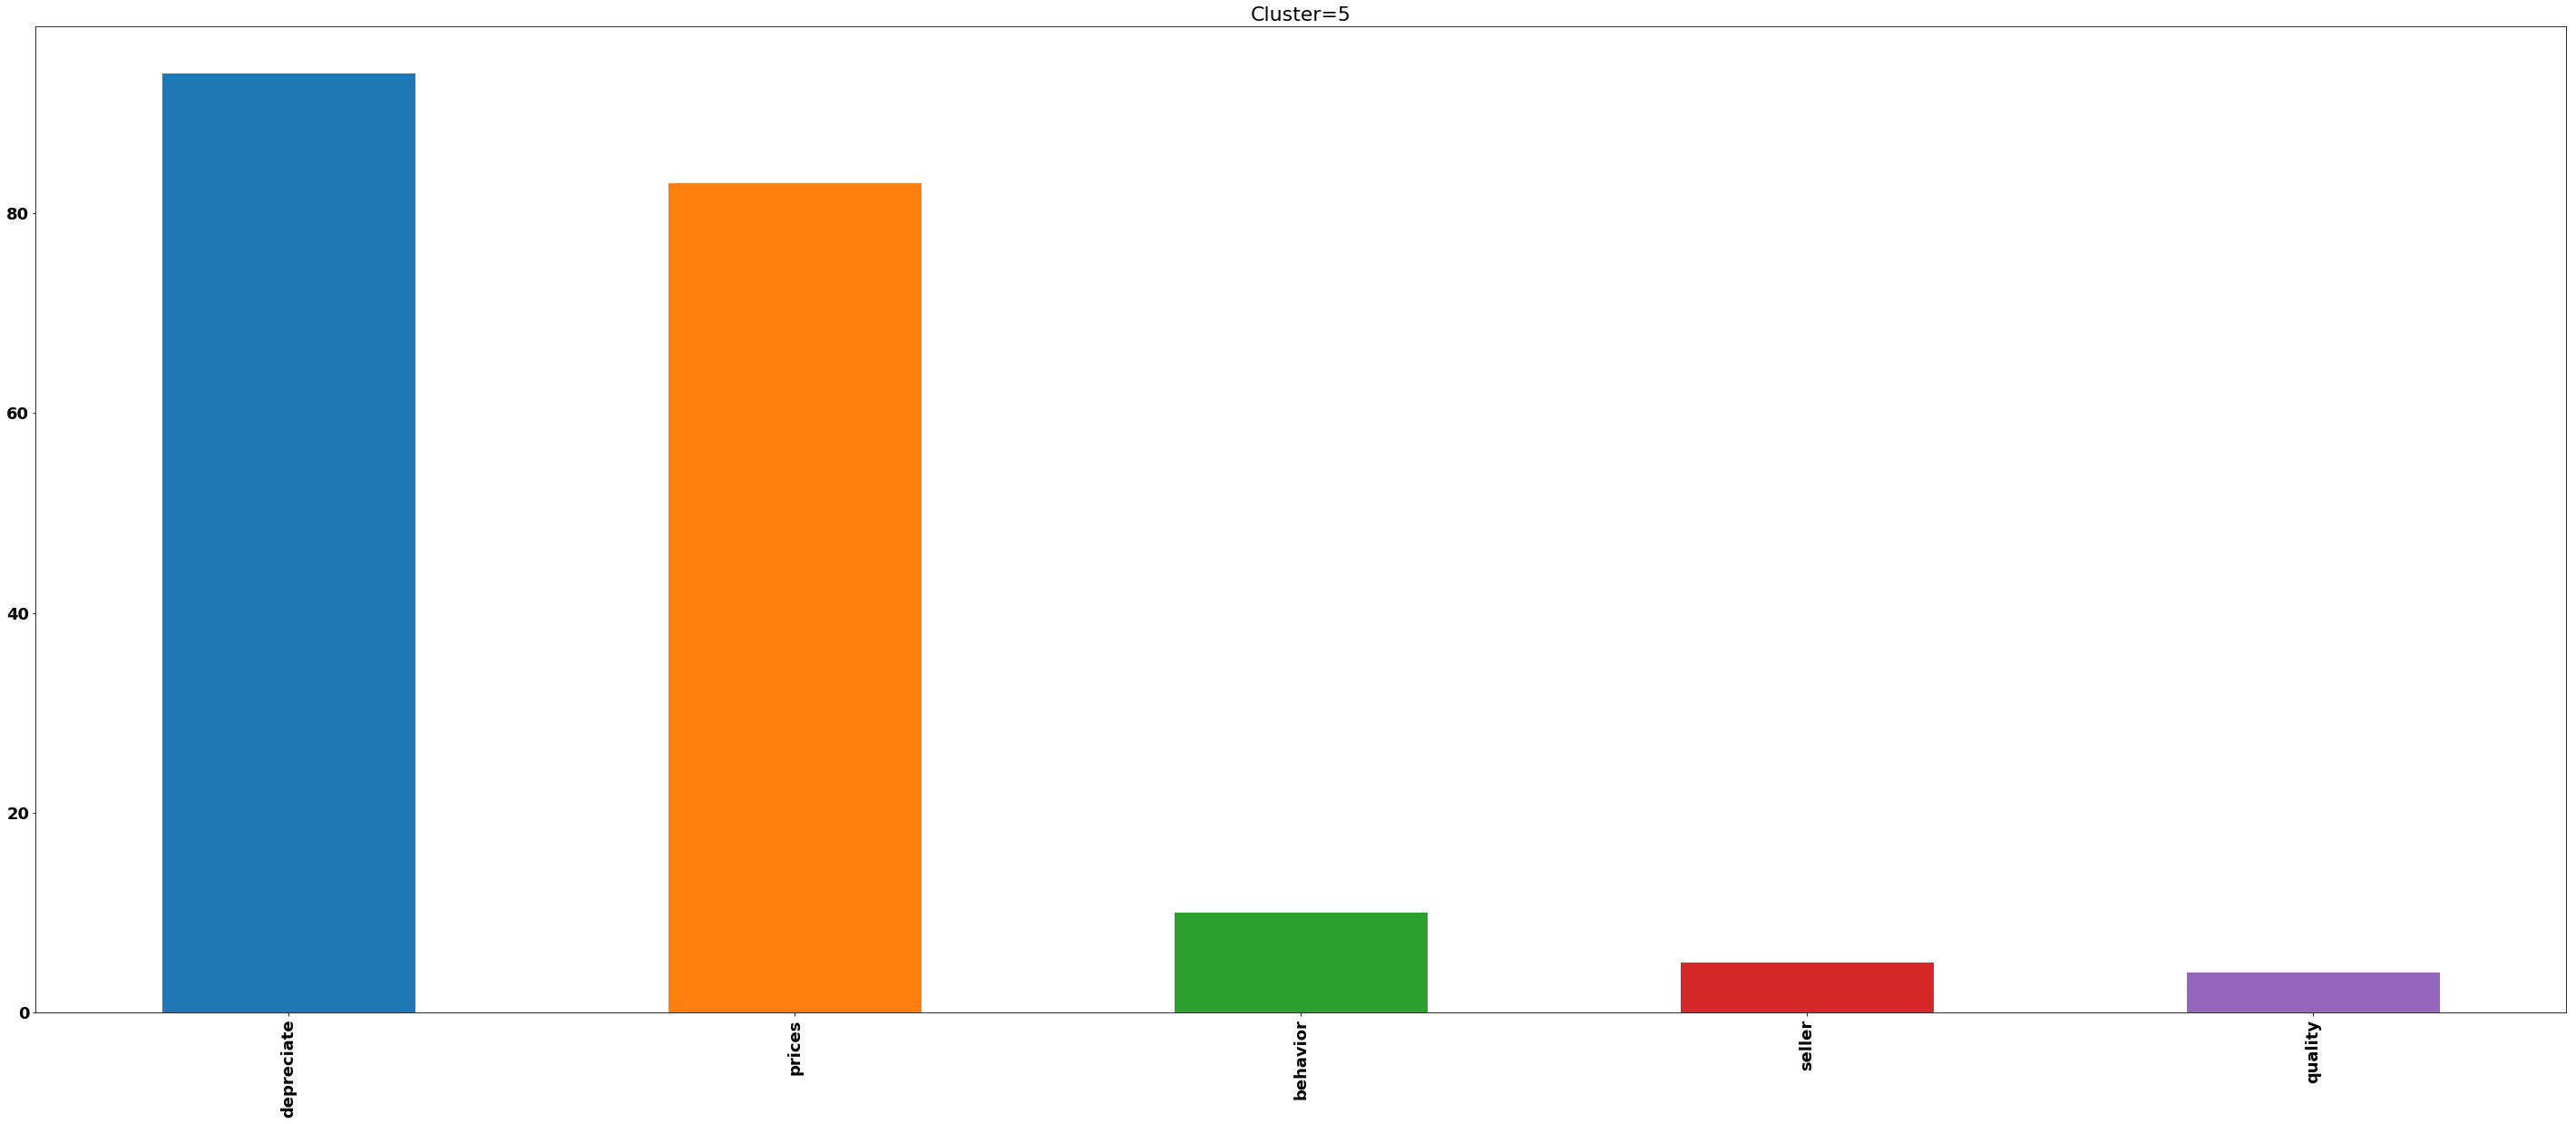

In [101]:
for i, group in enumerate(group_keywords):
    top_keywords = pd.value_counts(group).head(5)
    plt.title(f'Cluster={i}')
    top_keywords.plot.bar()
    plt.show()

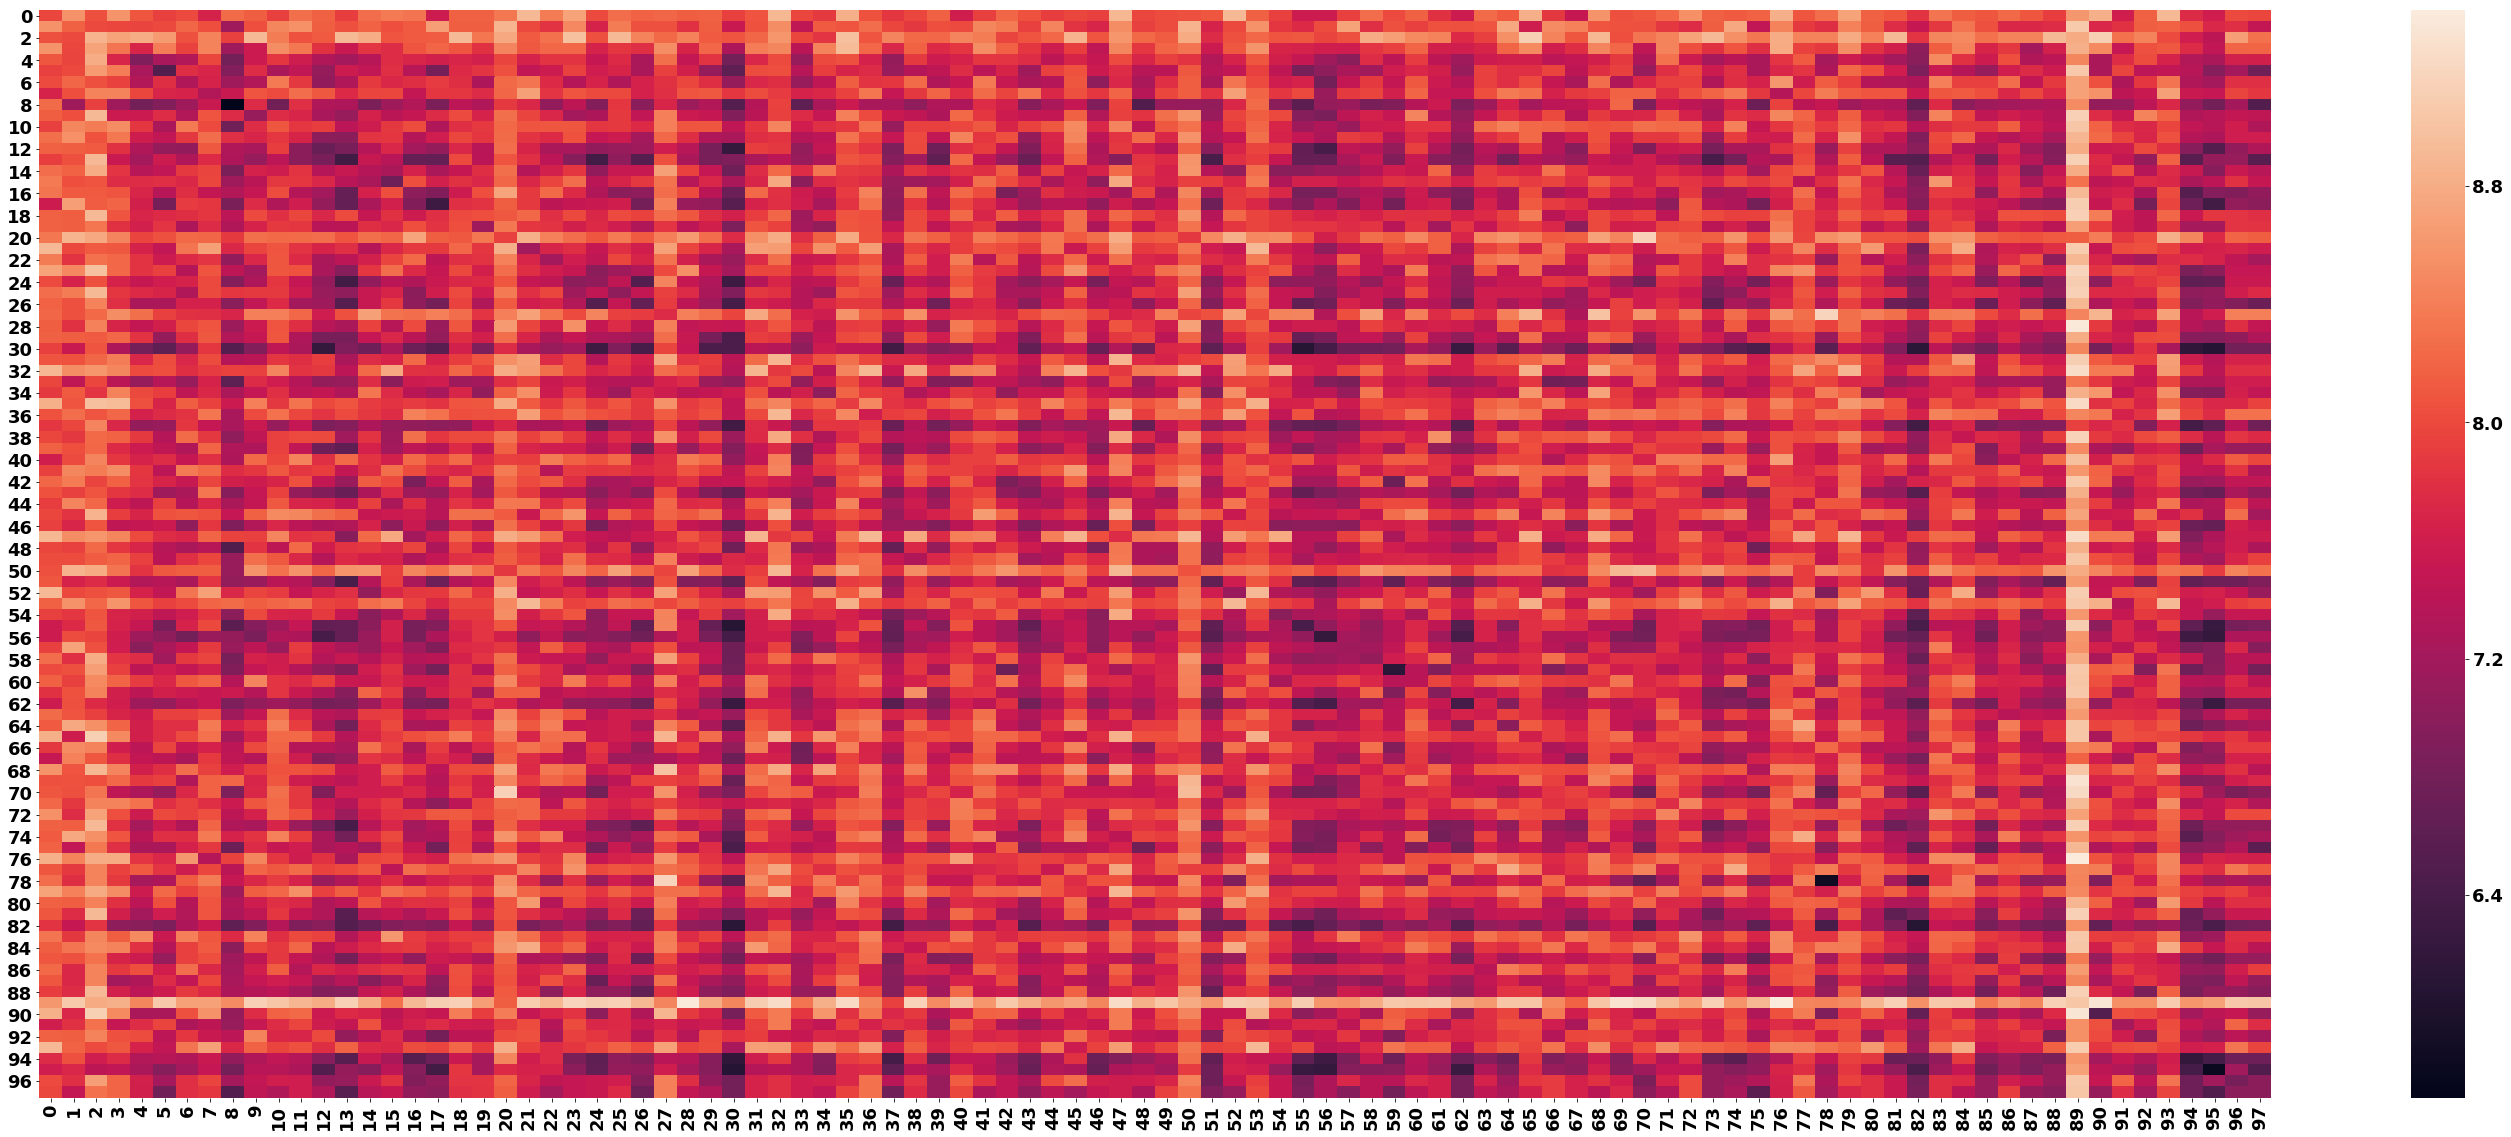

In [103]:
sns.heatmap(maximum_distance_matrix)

### Average Distance Clustering

In [106]:
# %%timeit -r 1

average_distance_matrix, average_distance_keyword = compute_abstract_space(average_keyword_distance)

TypeError: cannot unpack non-iterable NoneType object

## Provided Categorical Clustering

In [88]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
import scipy.cluster.hierarchy as shc

### Exploratory Data Analysis

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

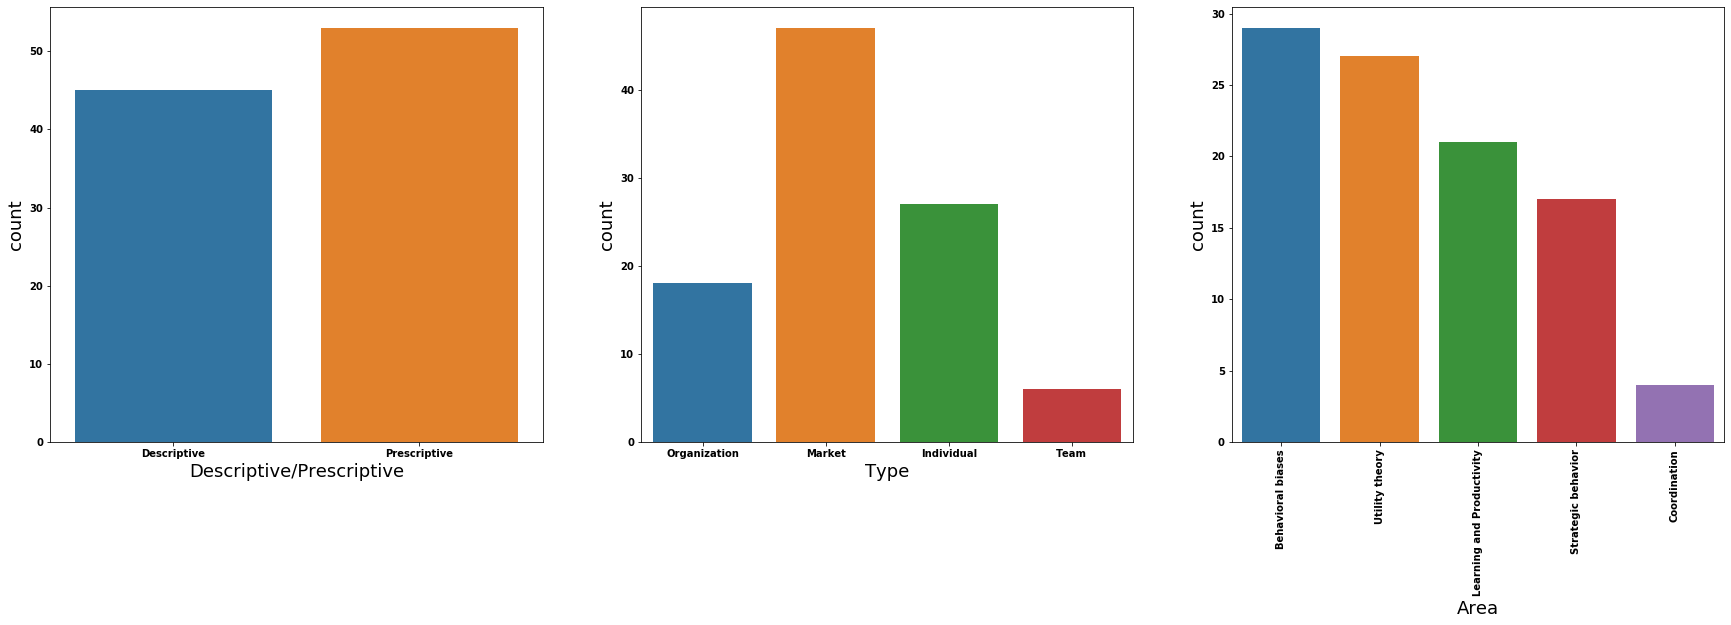

In [202]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 8))
sns.countplot(x='Descriptive/Prescriptive', data=df, ax=axes[0])
sns.countplot(x='Type', data=df, ax=axes[1])
sns.countplot(x='Area', data=df, ax=axes[2])
plt.xticks(rotation=90)

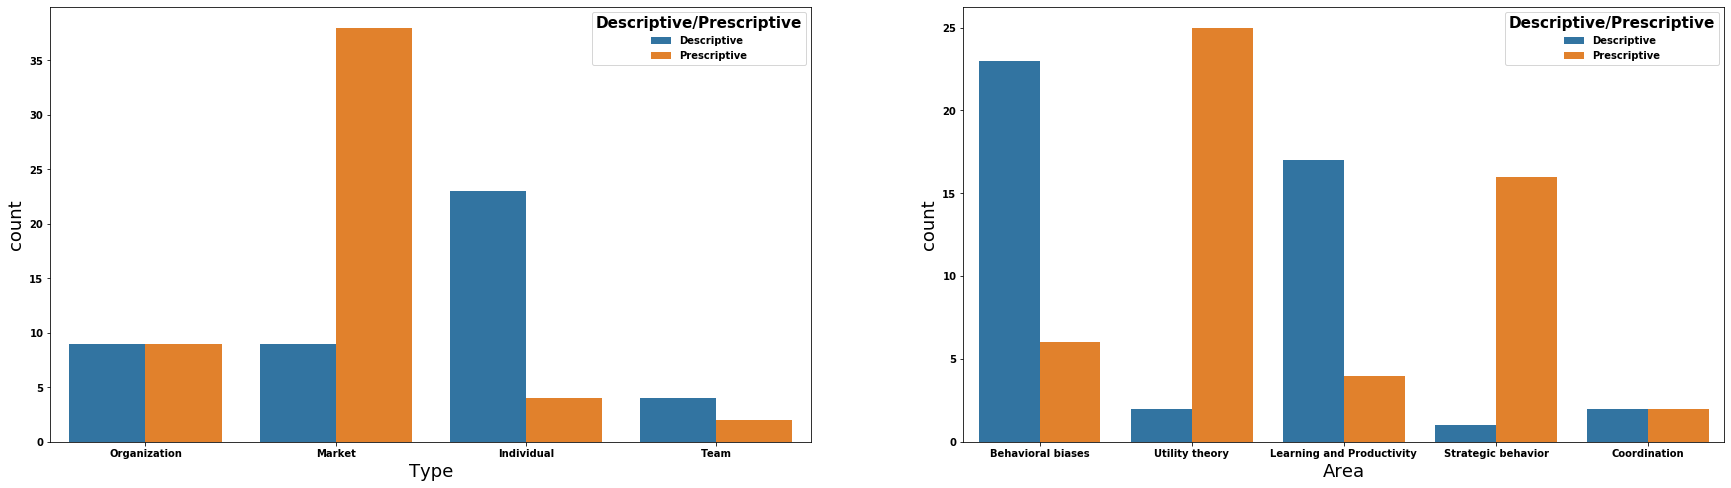

In [206]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))
sns.countplot(x='Type', hue='Descriptive/Prescriptive', data=df, ax=axes[0])
sns.countplot(x='Area', hue='Descriptive/Prescriptive', data=df, ax=axes[1])

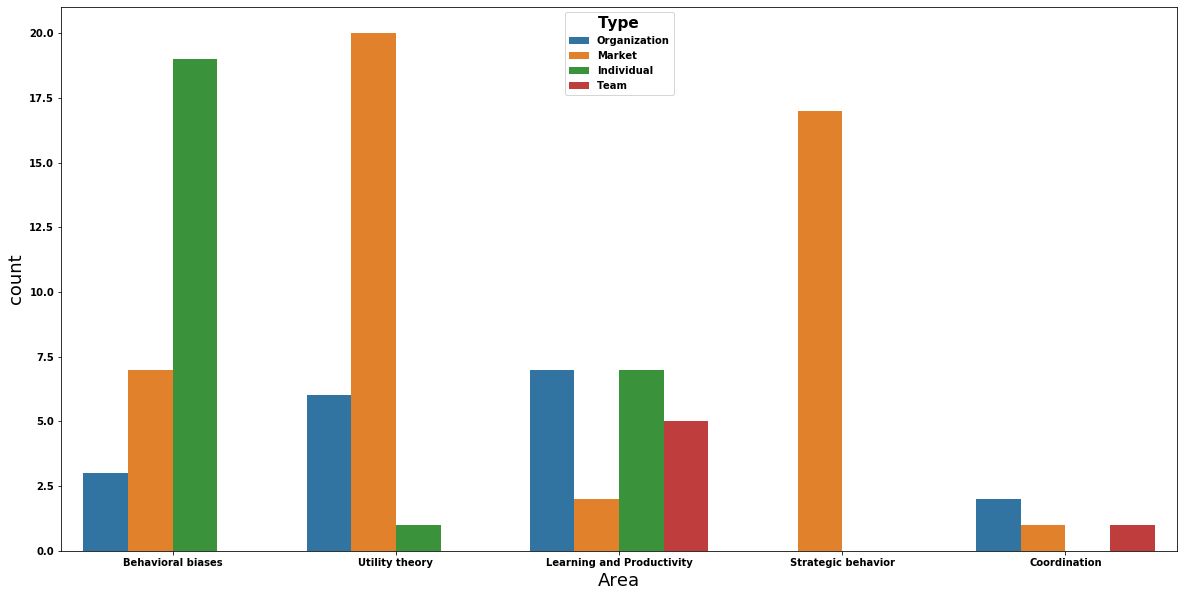

In [211]:
plt.figure(figsize=(20, 10))  
sns.countplot(x='Area', hue='Type', data=df)

### Hierarchical Clustering on Numerical Data

In [93]:
def encode_df(df):
    ohe = OneHotEncoder()
    sparse_data = ohe.fit_transform(df[['Descriptive/Prescriptive', 'Type', 'Area']])
    
    return pd.SparseDataFrame(sparse_data, columns=ohe.get_feature_names()).set_index(df["URL"], drop=True)

encoded_df = encode_df(df)

In [94]:
def hierarchical_clustering(X, n_clusters):
    return shc.fcluster(shc.linkage(X, method='ward'), n_clusters, criterion='maxclust')

#### Dendogram Plot

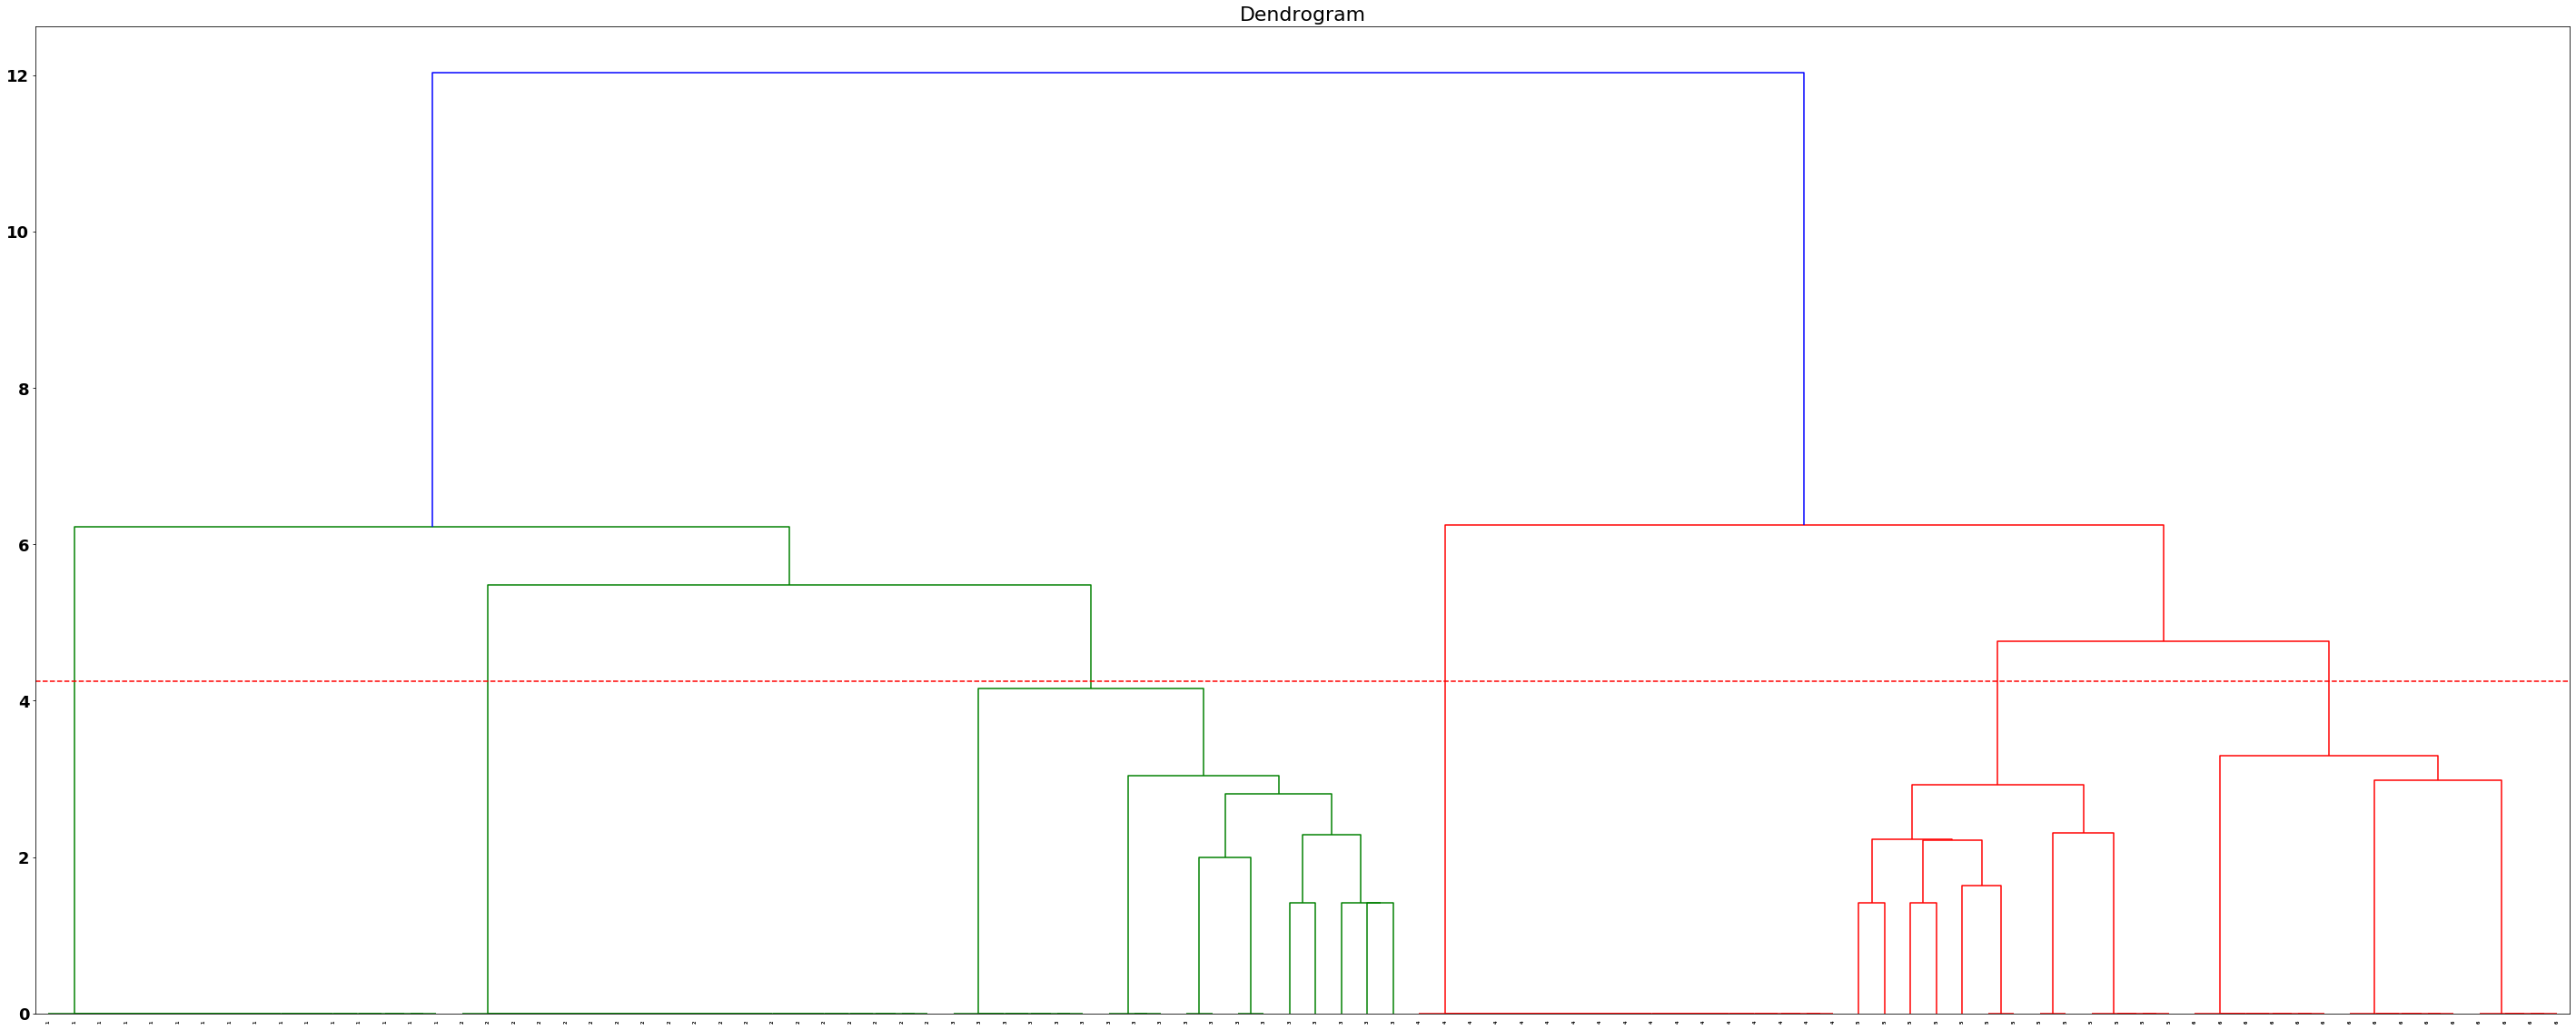

In [334]:
plt.title("Dendrogram")
plt.axhline(y=4.25, c='r', ls='--')
dend = shc.dendrogram(shc.linkage(encoded_df, method='ward'), labels=hierarchical_clustering(encoded_df, 6))
plt.savefig('plots/cluster_dendogram.pdf', format='pdf')

## Cluster Evaluation

In [95]:
def evaluate_clusters(X, n_clusters, clustering_func):
    fig, ax1 = plt.subplots(figsize=(30, 15))
    
    clusters = clustering_func(n_clusters)
    
    silhouette_avg = silhouette_score(X, clusters)
    samples = silhouette_samples(X, clusters)
    
    y_lower = 10
    for i in range(0, n_clusters):
        cluster_silhouette_scores = samples[clusters == i]
        cluster_silhouette_scores.sort()
        
        cluster_size = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + cluster_size
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    plt.title(f'Silhouette Graph (k={n_clusters})')
    
    ax1.set_yticks([])
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.text(silhouette_avg + 0.01,20,f'silhouette_avg={np.round(silhouette_avg, 4)}')
    plt.savefig(f'plots/silhouette/{n_clusters}_cluster_silhouette')
    plt.show()
   

### Minimum Distance Clustering

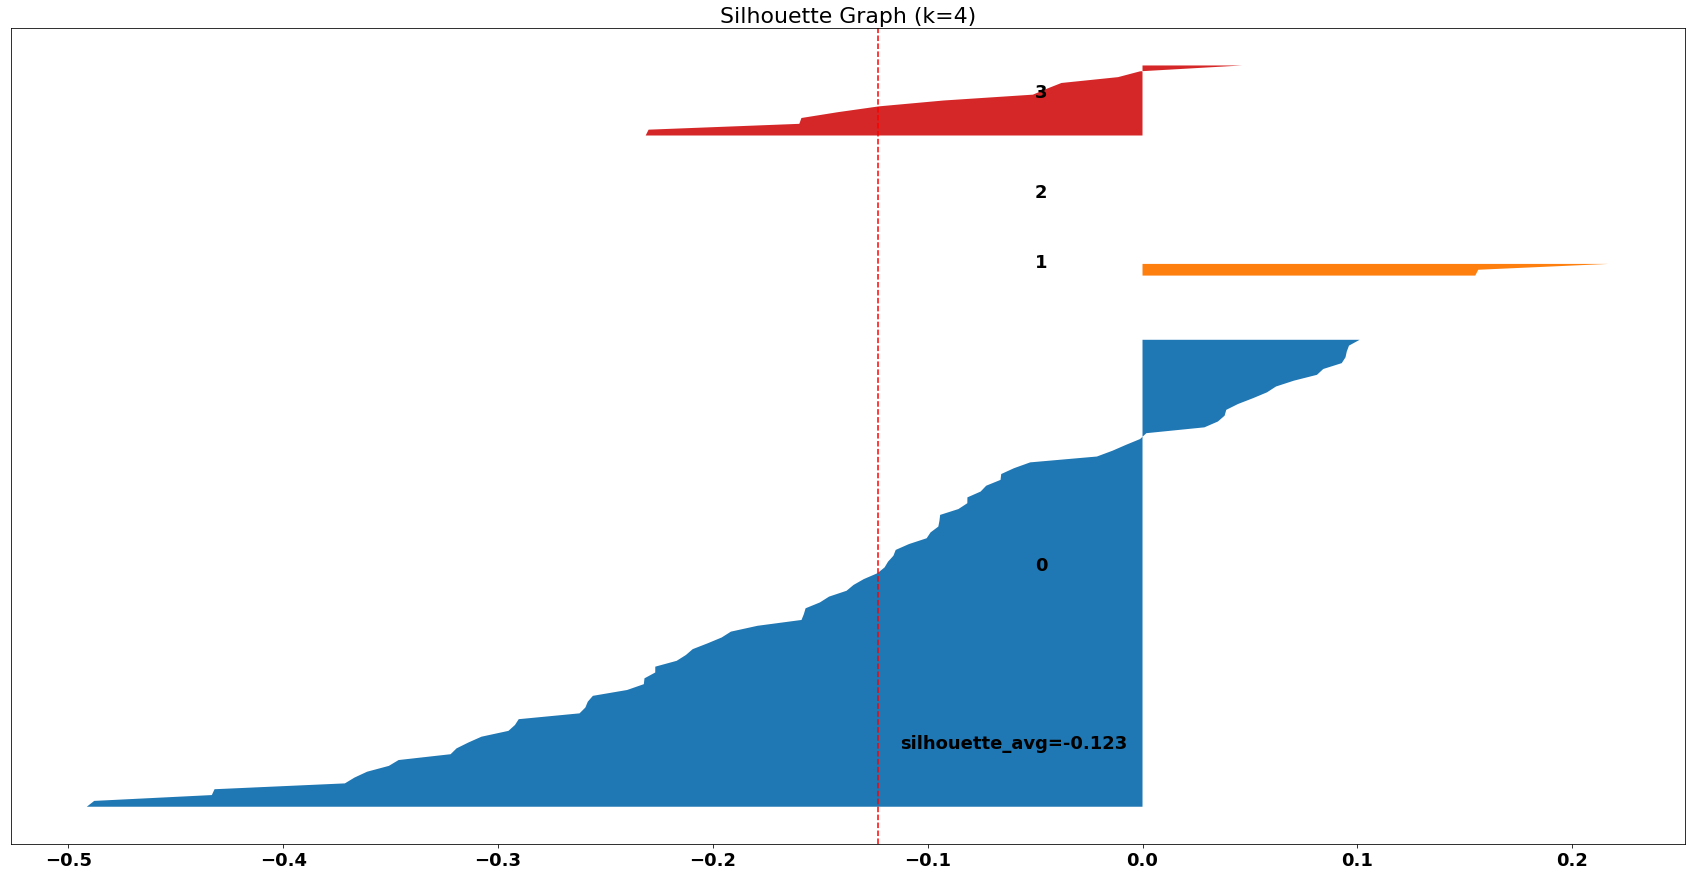

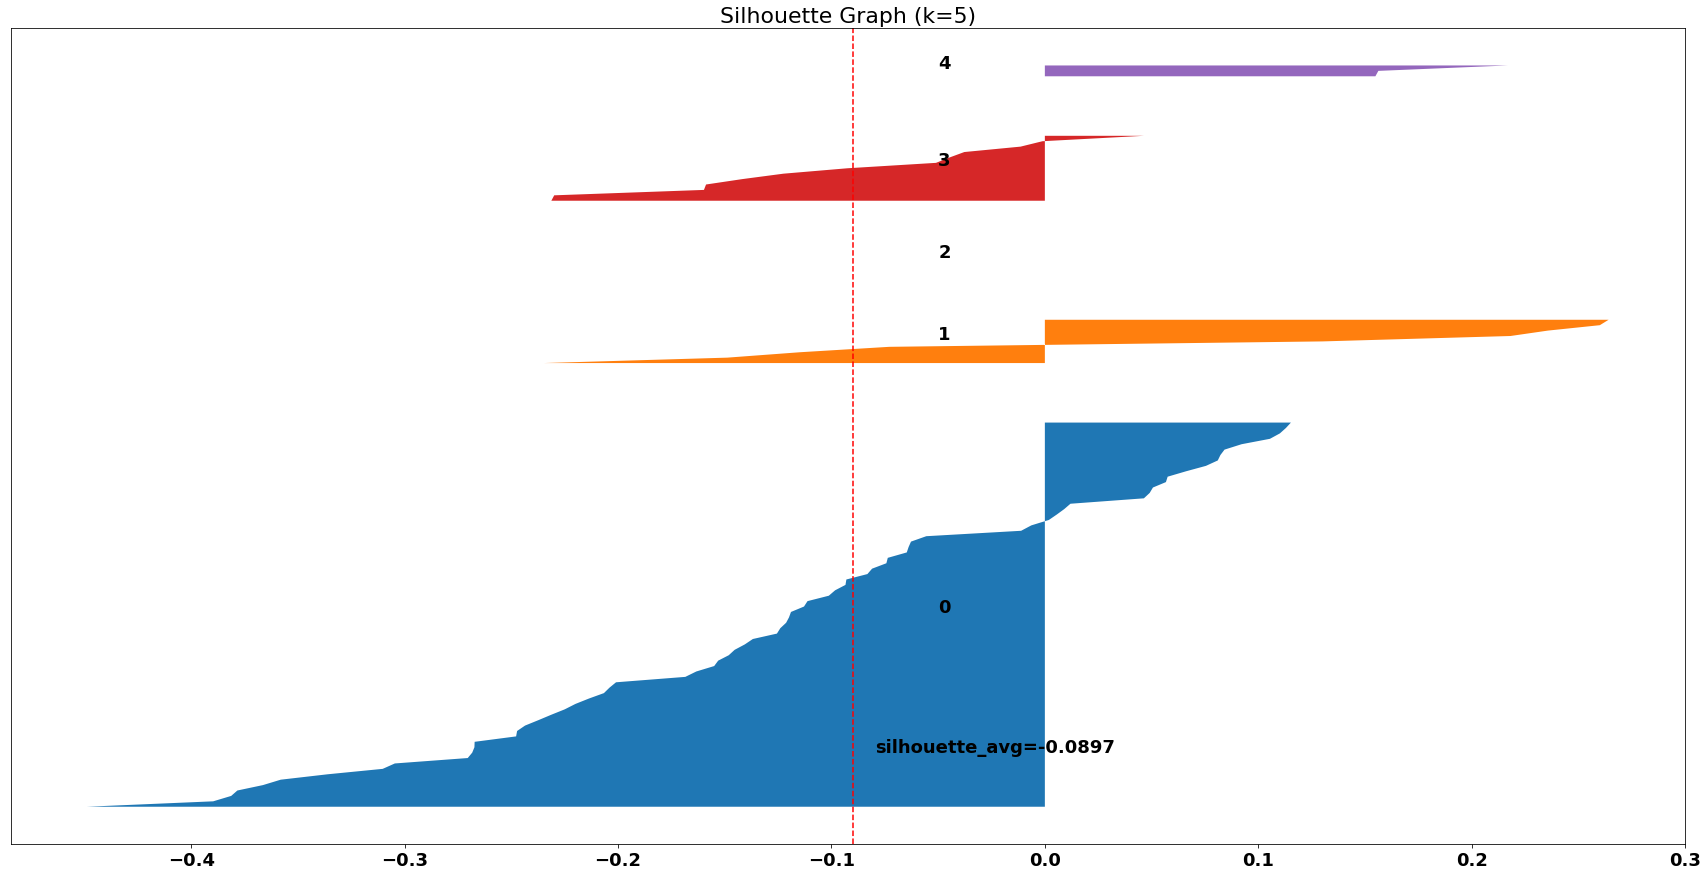

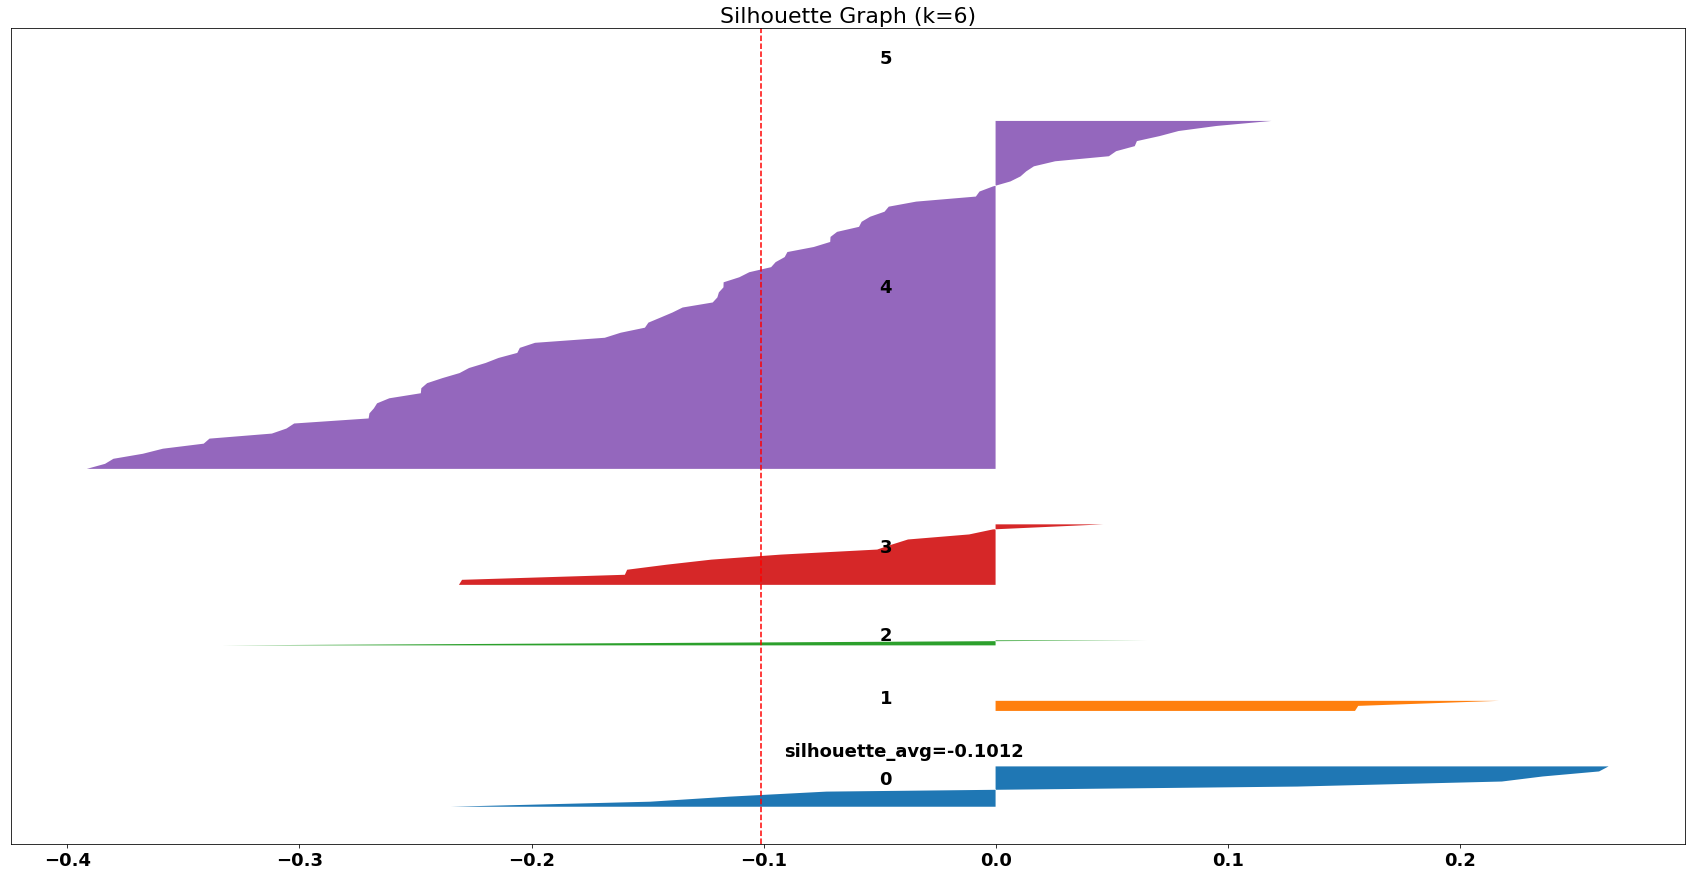

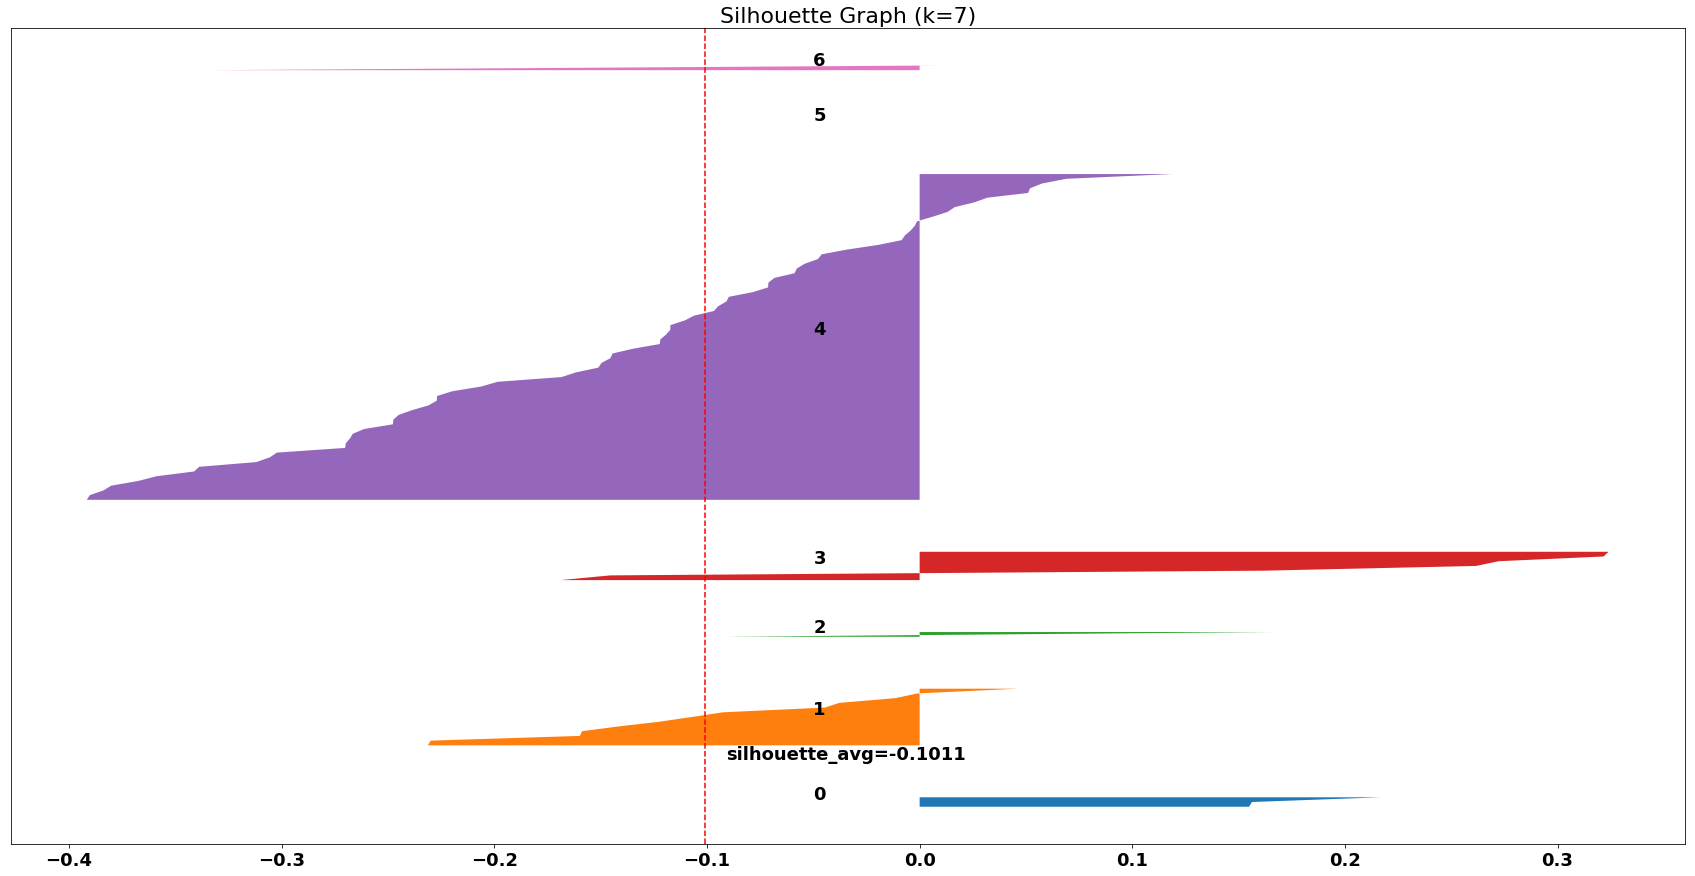

In [237]:
evaluate_clusters(minimum_distance_matrix, 4, minimum_distance_clustering)
evaluate_clusters(minimum_distance_matrix, 5, minimum_distance_clustering)
evaluate_clusters(minimum_distance_matrix, 6, minimum_distance_clustering)
evaluate_clusters(minimum_distance_matrix, 7, minimum_distance_clustering)

### Maximum Distance Clustering

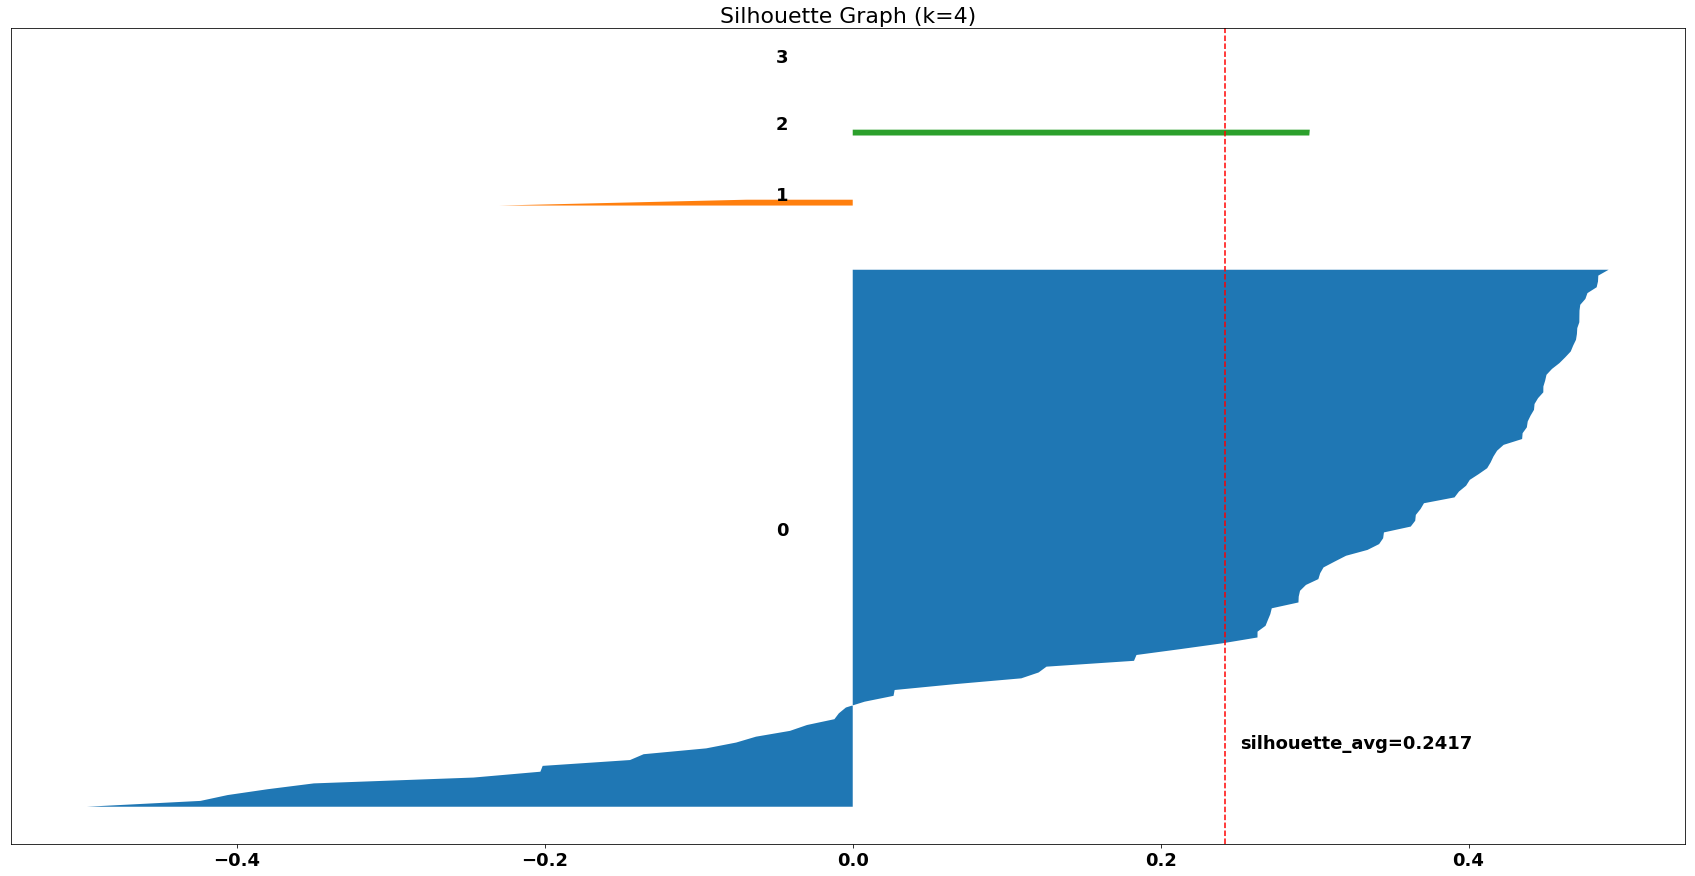

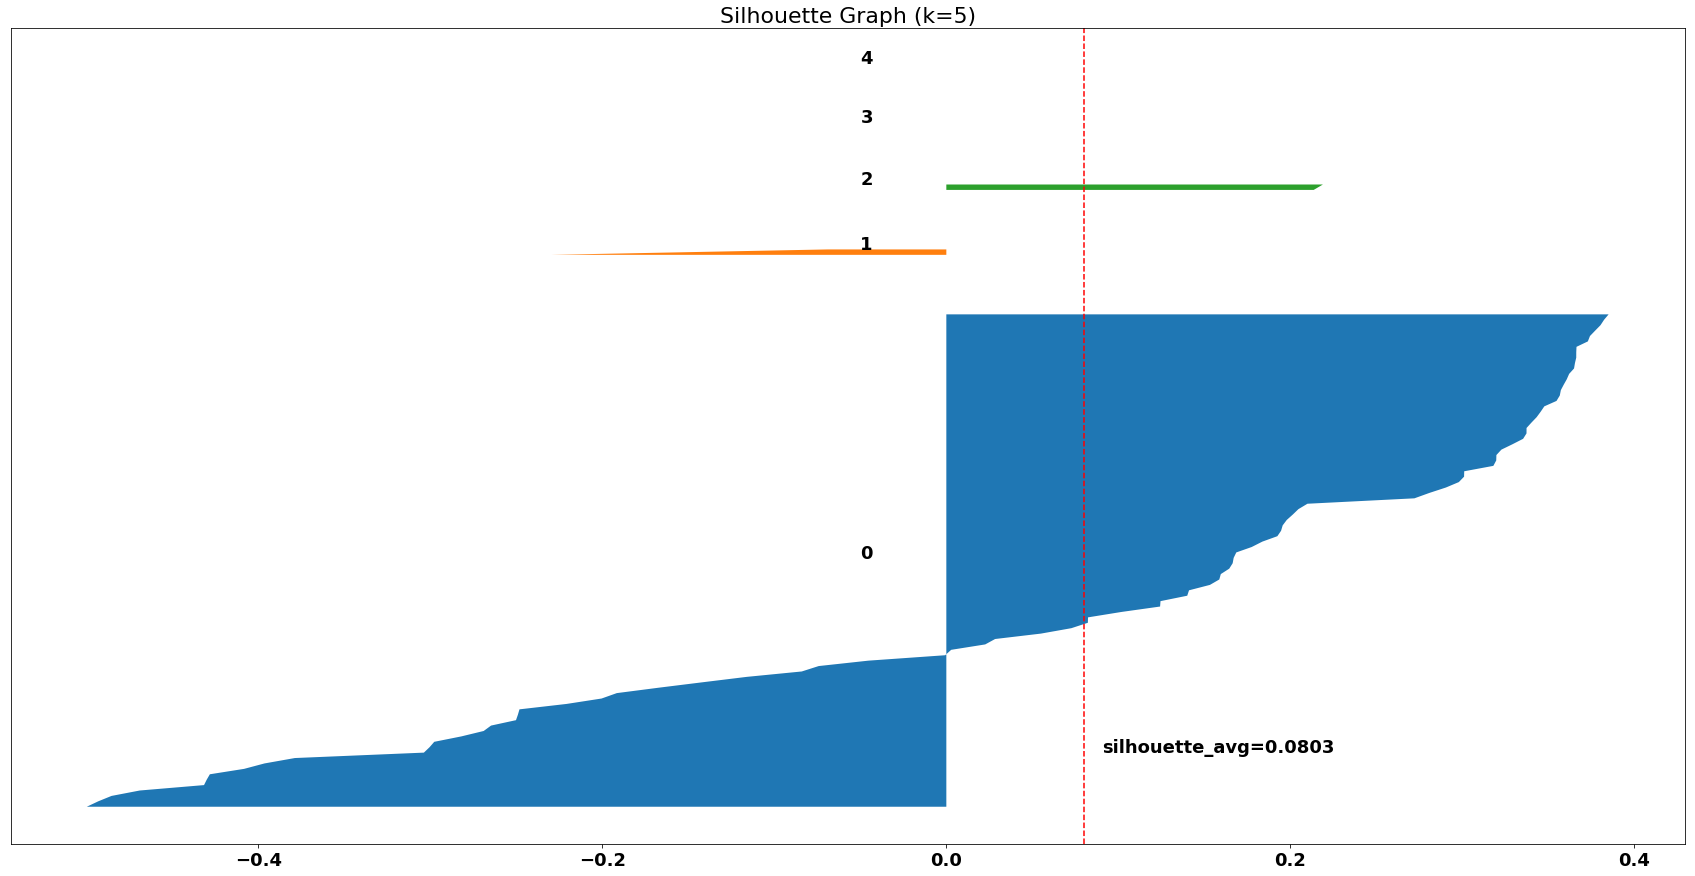

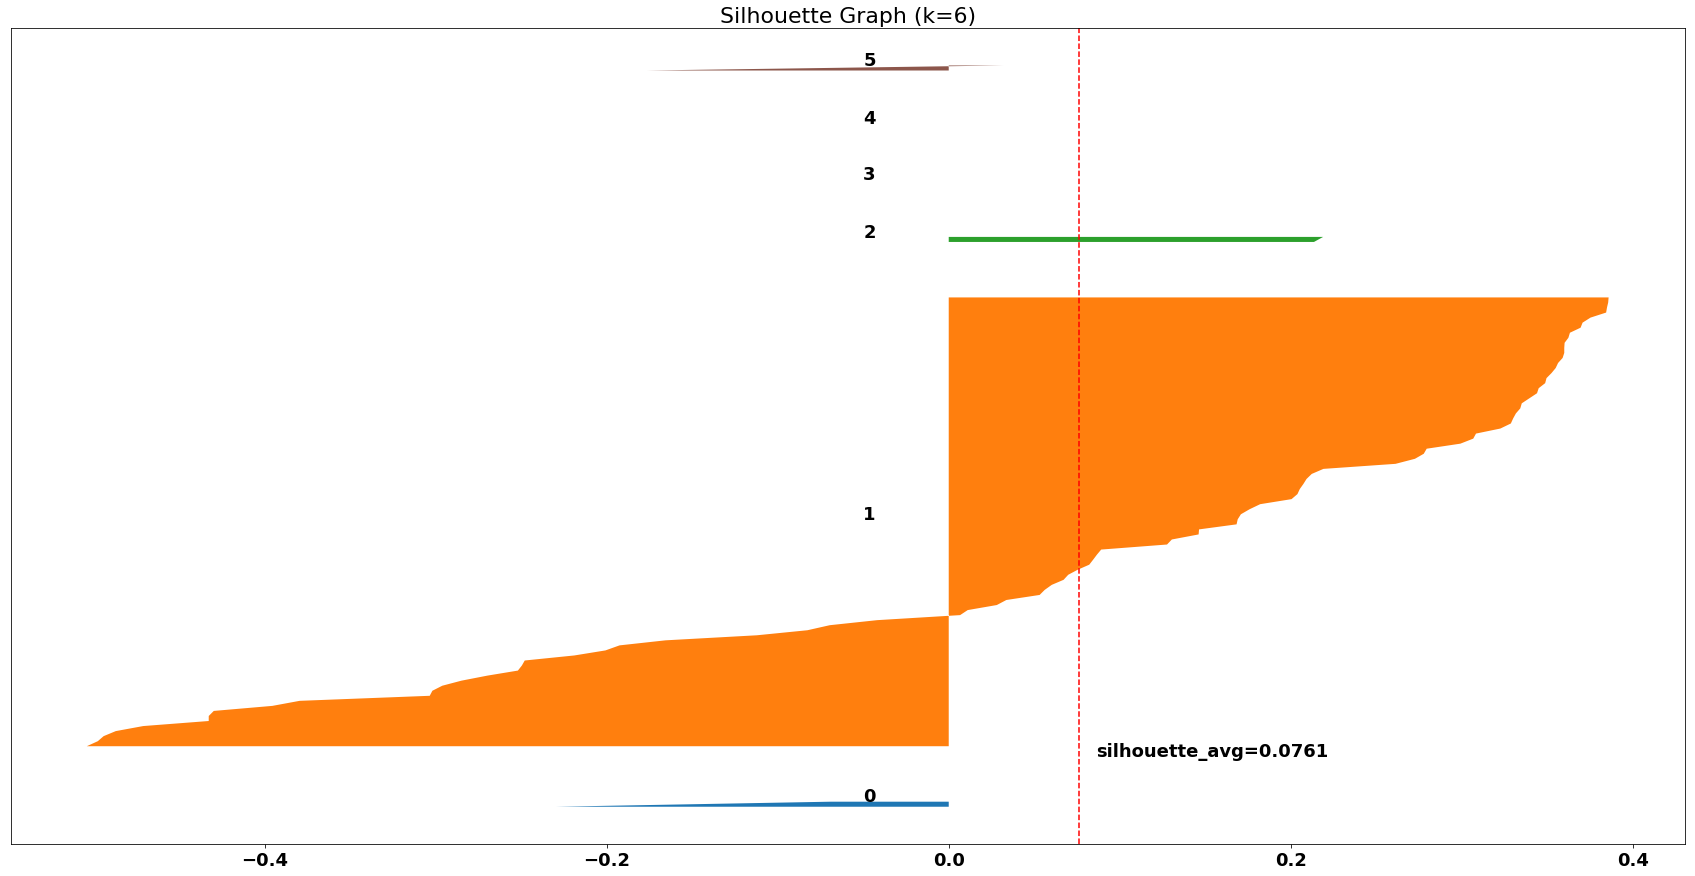

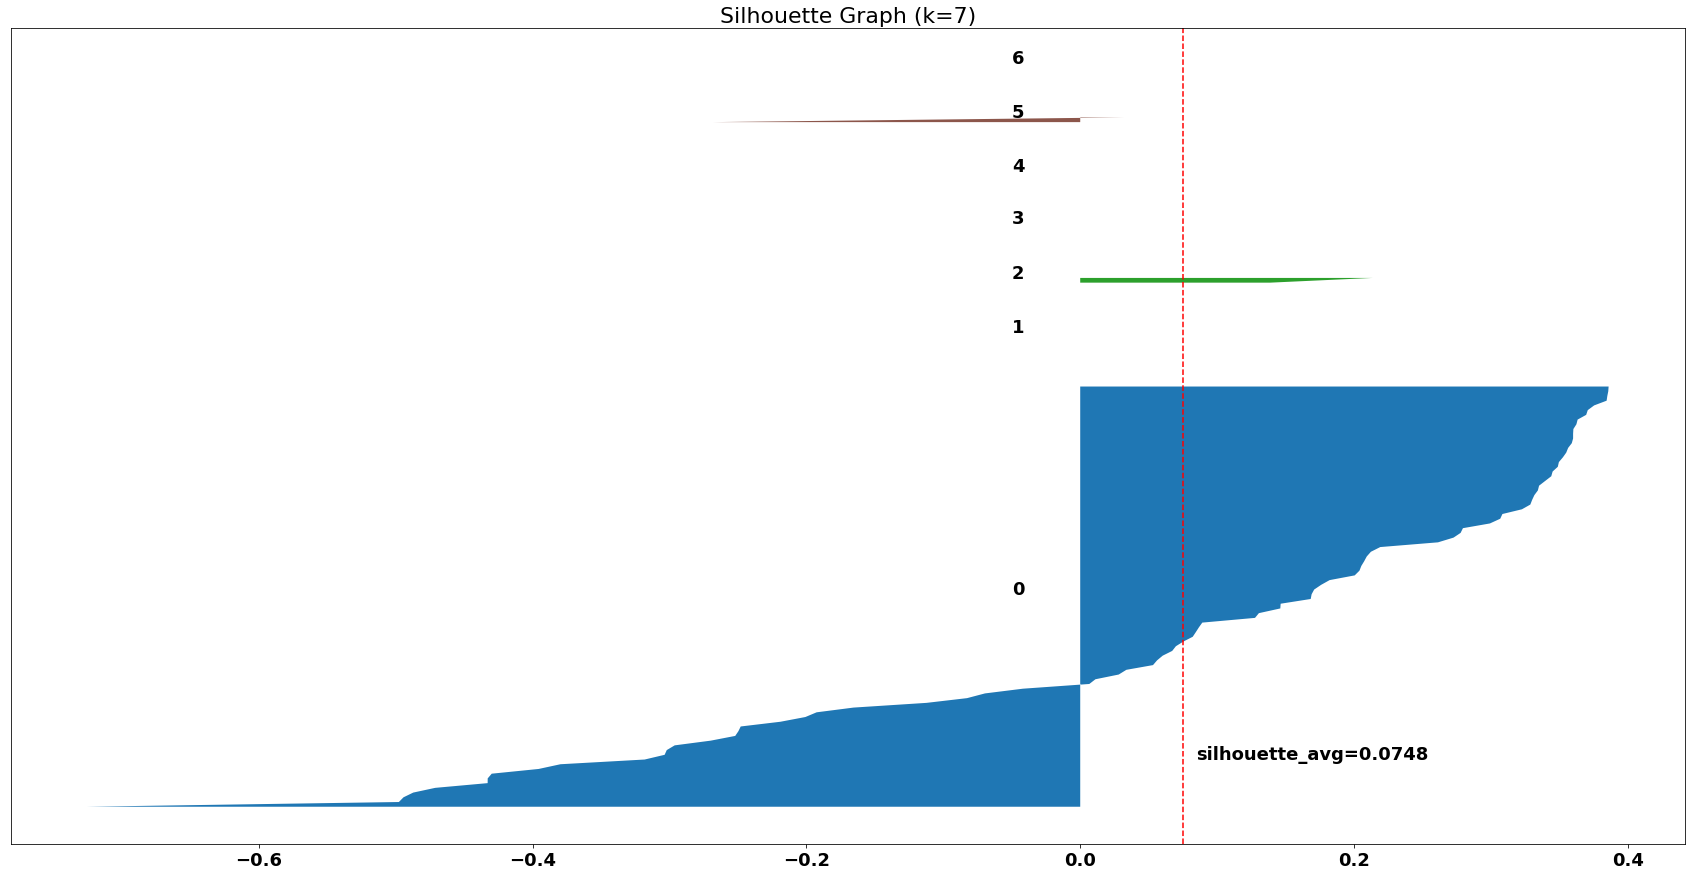

In [105]:
evaluate_clusters(maximum_distance_matrix, 4, maximum_distance_clustering)
evaluate_clusters(maximum_distance_matrix, 5, maximum_distance_clustering)
evaluate_clusters(maximum_distance_matrix, 6, maximum_distance_clustering)
evaluate_clusters(maximum_distance_matrix, 7, maximum_distance_clustering)

In [199]:
evaluate_clusters(X, hierarchical_clustering(X, 4))
evaluate_clusters(X, hierarchical_clustering(X, 5))
evaluate_clusters(X, hierarchical_clustering(X, 6))
evaluate_clusters(X, hierarchical_clustering(X, 7))
evaluate_clusters(X, hierarchical_clustering(X, 8))

In [280]:
hierarchical_clustering(X, 6)

array([5, 3, 5, 5, 4, 2, 4, 2, 6, 4, 3, 4, 1, 3, 2, 6, 1, 6, 3, 1, 4, 6,
       3, 3, 5, 3, 5, 6, 5, 1, 3, 3, 1, 4, 1, 5, 3, 3, 6, 4, 6, 3, 4, 1,
       6, 6, 2, 1, 1, 1, 2, 2, 6, 2, 2, 5, 1, 4, 3, 1, 1, 2, 2, 6, 2, 5,
       4, 4, 4, 4, 3, 2, 4, 1, 2, 2, 4, 2, 3, 3, 1, 4, 6, 6, 5, 6, 1, 3,
       2, 5, 4, 2, 2, 6, 5, 5, 2, 3], dtype=int32)

In [293]:
minimum_distance_clusters

array([1, 0, 1, 1, 5, 4, 5, 4, 2, 5, 0, 5, 3, 0, 4, 2, 3, 2, 0, 3, 5, 2,
       0, 0, 2, 0, 1, 2, 2, 3, 0, 0, 3, 5, 3, 1, 0, 0, 2, 5, 2, 0, 5, 3,
       2, 2, 4, 3, 3, 3, 4, 4, 2, 4, 4, 1, 3, 5, 0, 3, 3, 4, 4, 2, 4, 1,
       5, 5, 5, 5, 0, 4, 5, 3, 4, 4, 5, 4, 0, 0, 3, 5, 2, 2, 1, 2, 3, 0,
       4, 1, 5, 4, 4, 2, 1, 1, 4, 0])

In [282]:
(pd.Series(minimum_distance_clusters).replace({1: 5, 0: 3, 5: 4, 4: 2, 2: 6, 3: 1}) == hierarchical_clustering(X, 6)).sum()

96

## Conclusion

In [200]:
# df['cluster'] = hierarchical_clustering(X, 6)

NameError: name 'hierarchical_clustering' is not defined

In [136]:
df.to_csv('data/clusters.csv')